# Taxi Service Trajectory

## Problema de Negócio


### Sobre o Negócio:
- Com as novas tecnologias atuais, a indústria de táxis precisou se reinventar para não ficar para trás em relação aos seus novos concorrentes;
- Um dos desafios é a adaptação ao novo sistema eletrônico de despacho em tempo real, instalados nos veículos.

### Sobre o Problema:
- O sistema conta com um problema: a falta de informação sobre o destino final das corridas, pois os motoristas não indicam o destino;
- Com as mensagens unicast (1:1) os despachantes precisam identificar corretamente qual táxi enviar para uma localização de coleta, o que se torna difícil quando não se sabe o destino final dos táxis em serviço;
- Em razão desse problema, a proposta é desenvolver um modelo preditivo que seja capaz de inferir o destino final de corridas de táxi com base em suas localizações de coleta.

### Benefícios da solução:
- Assim, é possível melhorar a eficiência do sistema de despacho eletrônico de taxistas, permitindo uma identificação ágil de qual motorista encaminhar para cada solicitação de corrida, especialmente durante períodos de alta demanda.
- Redução do tempo de espera dos clientes, minimizar distâncias percorridas sem passageiros e, consequentemente, melhorar eficiência operacional e a satisfação do cliente.

## Objetivos

- Entender o problema de negócio
- Análise de dados
- PowerPoint descrevendo o problema e conclusões
- Enviar notebook (.ipynb) e apresentação (.pdf)

## 0. Imports

### 0.1. Bibliotecas

In [1]:
### Data manipulation
import pandas                   as pd
import numpy                    as np
import datetime                 as dt

from ast                        import literal_eval
from math                       import radians, sin, cos, sqrt, atan2

### Visualization
import seaborn                  as sns
import matplotlib               as mpl
import matplotlib.pyplot        as plt
import folium

from folium                     import Marker

### Feature engineering
from sklearn.model_selection    import train_test_split

### Machine learning
import lightgbm                 as lgb

from sklearn.model_selection    import GridSearchCV

### Evaluation
from sklearn.metrics            import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

### Other
import inflection
import warnings
import re

### 0.2. Configurações

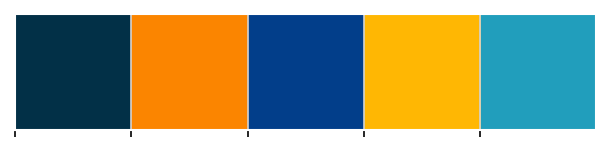

In [2]:
### Ignoring warnings
warnings.filterwarnings('ignore')

### Pandas Settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

### Visualization Settings
%matplotlib inline

mpl.style.use('ggplot')

mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['figure.titlesize']    = 25
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['font.size']           = 12
mpl.rcParams['axes.grid']           = True
mpl.rcParams['figure.dpi']          = 150

### Palette Seting
taxi_palette = ['#023047', '#fb8500', '#023e8a', '#ffb703', '#219ebc']
sns.set_palette(sns.color_palette(taxi_palette))
sns.palplot(sns.color_palette(taxi_palette))

### Random Seed
SEED = 42

### 0.3. Funções

In [3]:
##### Functions

### Data manipulation

def df_shape(df):
    """
    Summary: The function prints the number of rows and columns of a given DataFrame.

    Args:
        df: the DataFrame we want to know more about.
    
    Returns: a text indicating the number of rows and columns of the DataFrame.
    """

    print('Number of rows: {:,}'.format(df.shape[0]))
    print('Number of columns: {:,}'.format(df.shape[1]))

    return None

### Visualization

def set_image(fig, title, xlabel, ylabel, xrotation=0, yrotation=0):
    """
    Summary: This function sets the image configuration.

    Args:
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
        rotation: the rotation of the labels. default as 0.

    Returns: None
    """

    plt.title(title)
    plt.xlabel(xlabel, color='black')
    plt.ylabel(ylabel, color='black')
    plt.xticks(rotation=xrotation)
    plt.yticks(rotation=yrotation)
    plt.tick_params(left=False, bottom=False)

    return fig

def create_map(coordinates):
    """
    Summary:
        Creates a folium map for the trajectory of the taxis.
    Args:
        coordinates: the coordinates of the polyline.
    Returns:
        map: the folium map.
    """
    # Centering the map on the starting point
    map_center = [coordinates[0][1], coordinates[0][0]]
    
    # Creating a folium map
    map = folium.Map(location=map_center, zoom_start=15)

    # Creating a polyline from the coordinates
    polyline = folium.PolyLine(
        locations=[(lat, lon) for lon, lat in coordinates],
        color='blue',
        weight=5)

    # Add the polyline to the map
    polyline.add_to(map)

    # Display the map
    return map

### Preprocessing functions

# Function to calculate Haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Summary:
        Calculates the Haversine distance between two points on the Earth's surface.
    Args:
        lat1 (float): Latitude of the first point.
        lon1 (float): Longitude of the first point.
        lat2 (float): Latitude of the second point.
        lon2 (float): Longitude of the second point.
    Returns:
        float: The Haversine distance between the two points in kilometers.
    """
    R = 6371  # Earth radius
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = (sin(dlat / 2) ** 2) + (cos(radians(lat1)) * cos(radians(lat2)) * (sin(dlon / 2) ** 2))
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    return distance

# Function to calculate total distance for a polyline
def calculate_total_distance(polyline):
    """
    Summary:
        Calculates the total distance of a polyline.
    Args:
        polyline (list): A list of tuples representing the polyline coordinates.
    Returns:
        float: The total distance of the polyline in kilometers.
    """
    total_distance = 0

    for i in range(len(polyline) - 1):
        lat1, lon1 = polyline[i]
        lat2, lon2 = polyline[i + 1]
        total_distance += haversine_distance(lat1, lon1, lat2, lon2)

    return total_distance

### 0.4. Carregando dados

In [4]:
df = pd.read_csv('../data/raw/train.csv')

## 1. Descrição dos dados

In [5]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.000,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


### 1.1. Dimensões

In [6]:
df_shape(df)

Number of rows: 1,710,670
Number of columns: 9


### 1.2. Tipos

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


### 1.3. Colunas

| Variable        | Description                                  | Type       |
|-----------------|----------------------------------------------|------------|
| `TRIP_ID`       | Identificação de cada viagem.          | `int`      |
| `CALL_TYPE`     | Identifica a maneira que o serviço aconteceu (A, B ou C)        | `object`   |
| `ORIGIN_CALL`   | Identificação de número de telefone que pediu táxi | `float` |
| `ORIGIN_STAND`  | Ponto de táxi em que o pedido foi realizado | `float` |
| `TAXI_ID`       | Identificação do Táxi              | `int`      |
| `TIMESTAMP`     | Timestamp indicando quando ocorreu a corrida   | `int`      |
| `DAY_TYPE`      | Indica o tipo de dia (A, B ou C)          | `object`   |
| `MISSING_DATA`  | Indica se há falta de dados      | `bool`     |
| `POLYLINE`      | Sequência de coordenadas geográficas do trajeto      | `object`   |


### 1.4. Dados faltantes

In [8]:
# Checking for null values
null_values = pd.DataFrame(
    {'NA':  df.isna().sum(), 
    '%NA': (df.isna().sum()) / (df.shape[0]) * (100)}
).sort_values('NA', ascending=False)

# Displaying the null values
null_values

,NA,%NA
ORIGIN_CALL,1345900,78.677
ORIGIN_STAND,904091,52.850
TRIP_ID,0,0.000
CALL_TYPE,0,0.000
TAXI_ID,0,0.000
TIMESTAMP,0,0.000
DAY_TYPE,0,0.000
MISSING_DATA,0,0.000
POLYLINE,0,0.000


## 2. Preprocessamento e exploração 

### 2.1. Transformando nomes de colunas

In [9]:
# List of columns
old_columns = df.columns.tolist()
# Lambda function
snake_case = lambda x: inflection.underscore(x)
# Apply the function to each column 
new_columns = list(map(snake_case, old_columns))
# Assigning new column names to DataFrame
df.columns = new_columns

### 2.2. Transformando tipos de dados

#### 2.2.1. Datetime

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [11]:
# Creating new columns
df['hour']       = df['timestamp'].dt.hour # Hour
df['day']        = df['timestamp'].dt.day # Day
df['month']      = df['timestamp'].dt.month # Month
df['year']       = df['timestamp'].dt.year # Year
df['dayofweek']  = df['timestamp'].dt.dayofweek # Day of week
df['weekofyear'] = df['timestamp'].dt.weekofyear # Week of year

# Column with only the day, month and year
df['day_month_year'] = df['timestamp'].dt.strftime('%d-%m-%Y')
df['day_month_year'] = pd.to_datetime(df['day_month_year'], format='%d-%m-%Y')

In [12]:
# Dict for day of week 
mapping = {
    0: 'Segunda',
    1: 'Terça',
    2: 'Quarta',
    3: 'Quinta',
    4: 'Sexta',
    5: 'Sábado',
    6: 'Domingo'}

# Mapping 
df['name_dayofweek'] = df['dayofweek'].map(mapping)

In [13]:
# Dict for month of the year
mapping = {
    7: 'Julho',
    8: 'Agosto',
    9: 'Setembro',
    10: 'Outubro',
    11: 'Novembro'}

# Mapping
df['name_month'] = df['month'].map(mapping)

In [14]:
df['year'].value_counts()

2013    858691
2014    851979
Name: year, dtype: int64

#### 2.2.2. Filtrando Dados
- Esta filtragem é realizada a fim de aumentar a eficiência computacional.
- Dados serão filtrados para o ano de 2013 e para os meses de Julho, Agosto, Setembro, Outubro e Novembro.

In [15]:
df = df[(df['year'] == 2013) & (df['month'].isin([7, 8, 9, 10, 11]))]

In [16]:
# 'Year' não é mais necessário
df.drop('year', axis=1, inplace=True)

In [17]:
df = df[df['missing_data'] == False]

#### 2.2.3. Polyline
- Convertendo a coluna `polyline` para uma lista de coordenadas ao invés de uma string.

In [18]:
df['polyline'] = df['polyline'].apply(literal_eval)

### 2.3. Dados Numéricos

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_id,712429.000,1379336927027695872.000,3819260779361558.000,1372636853620000256.000,1375986304620000512.000,1379543554620000768.000,1382586192620000256.000,1385855978620000256.000
origin_call,150286.000,23520.727,19649.486,2001.000,5591.000,17135.000,39718.000,63884.000
origin_stand,348015.000,30.296,17.816,1.000,15.000,27.000,49.000,63.000
taxi_id,712429.000,20000349.275,209.702,20000001.000,20000171.000,20000345.000,20000518.000,20000981.000
hour,712429.000,12.047,6.188,0.000,8.000,12.000,17.000,23.000
day,712429.000,15.727,8.858,1.000,8.000,16.000,23.000,31.000
month,712429.000,9.023,1.413,7.000,8.000,9.000,10.000,11.000
dayofweek,712429.000,3.026,1.955,0.000,1.000,3.000,5.000,6.000
weekofyear,712429.000,37.571,6.311,27.000,32.000,38.000,43.000,48.000


### 2.4. Dados Categóricos

In [20]:
print('Call Types:\n{}. \n'.format(df.call_type.value_counts()))
print('Day Types:\n{}.'.format(df.day_type.value_counts()))

Call Types:
B    351967
C    210176
A    150286
Name: call_type, dtype: int64. 

Day Types:
A    712429
Name: day_type, dtype: int64.


### 2.5. Exploratory Features

In [21]:
# Calculating distances and creating the column 'distance'
df['distance'] = df['polyline'].apply(calculate_total_distance)

#### 2.5.1. Visualizando as viagens mais longas

In [22]:
df.distance.sort_values(ascending=False).head(5)

543970   1333.169
224407   1145.597
691667   1111.335
601259    676.361
630175    665.826
Name: distance, dtype: float64

In [23]:
create_map(df['polyline'][543970])

In [24]:
create_map(df['polyline'][224407])

- Considerando os erros no dataset, como táxis dirigindo sobre a água e em linhas retas ao longo do mapa, as linhas com distâncias no top 2.5% serão suprimidas;
- Considerando também as viagens com distância igual a zero como erros, as distâncias no 2.5% mais baixo também serão suprimidas.

In [25]:
df.drop(df[(df['distance'] > df['distance'].quantile(0.975)) | (df['distance'] < df['distance'].quantile(0.025))].index, inplace=True)

## 3. Análise Exploratória de Dados

### 3.1. Quais os tipos de chamadas mais frequentes?

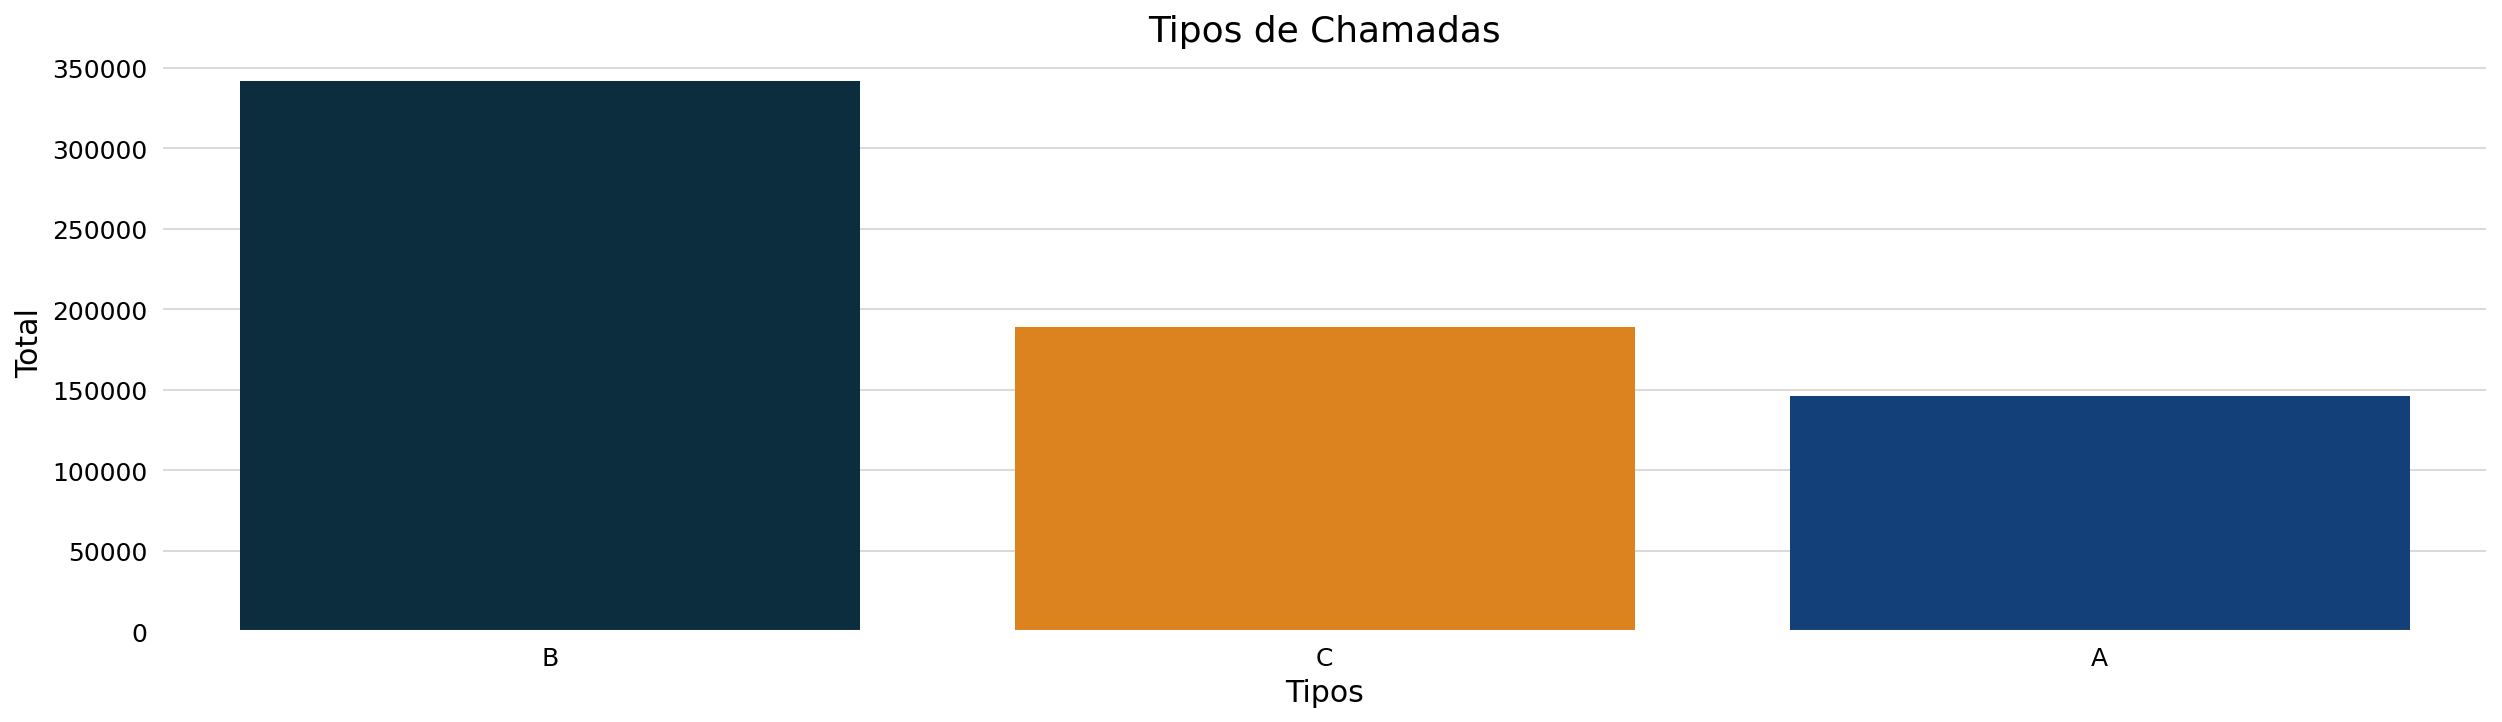

In [26]:
# Figure 
fig_01 = sns.countplot(data=df, x='call_type', order=df['call_type'].value_counts().index)

# Customizing
fig_01 = set_image(fig_01, 'Tipos de Chamadas', 'Tipos', 'Total');

- Percebe-se que o tipo mais comum de chamado é o **B**, onde o solicitante pede pela corrida no ponto de táxi;
- Em segundo lugar, o tipo **C** é a demanda aleatória, como solicitar pela corrida na via;
- Em último, o tipo **A** é aquela em que a corrida é enviada pela central da empresa.

### 3.2. Quais são os telefones que mais solicitaram corridas de táxi?

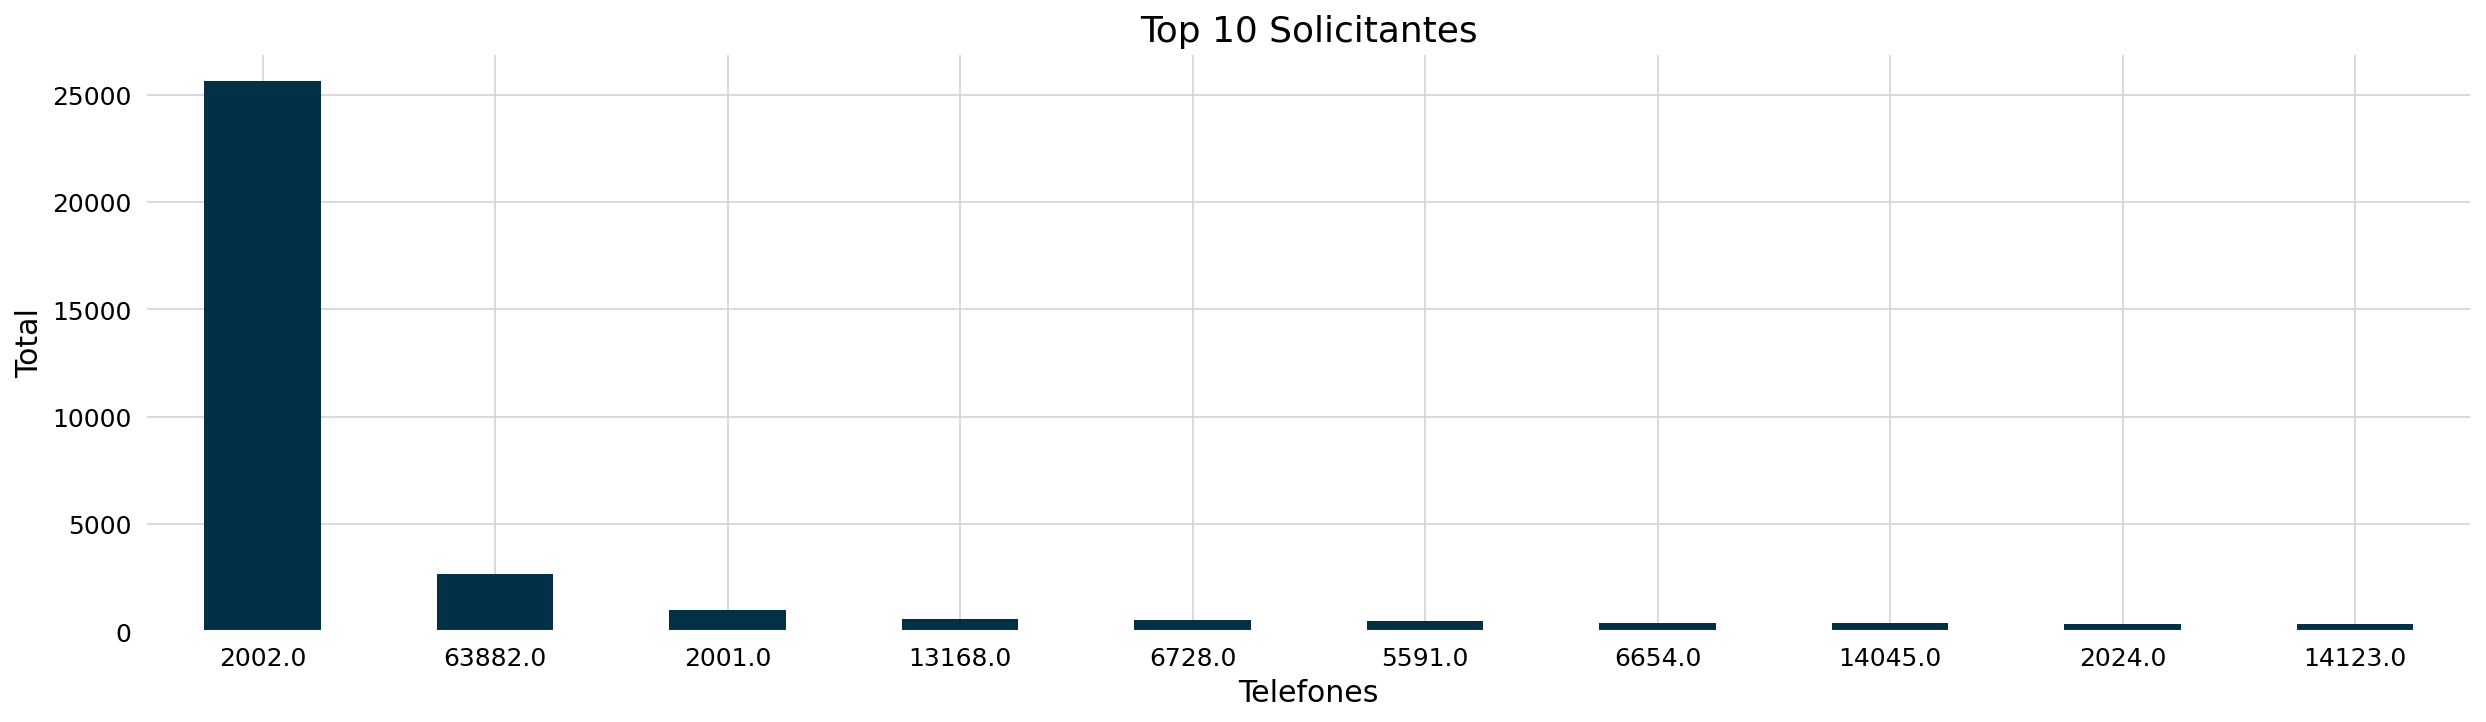

In [27]:
# Data manipulation
top_phone_numbers = df['origin_call'].value_counts().dropna().head(10)

# Figure
fig_02 = top_phone_numbers.plot(kind='bar')

# Customizing
fig_02= set_image(fig_02, 'Top 10 Solicitantes', 'Telefones', 'Total');

- Existe um telefone/cliente que solicita muito mais corridas para a central do que os outros clientes em geral.

### 3.3. Quais os pontos de táxi com origem mais frequentes?

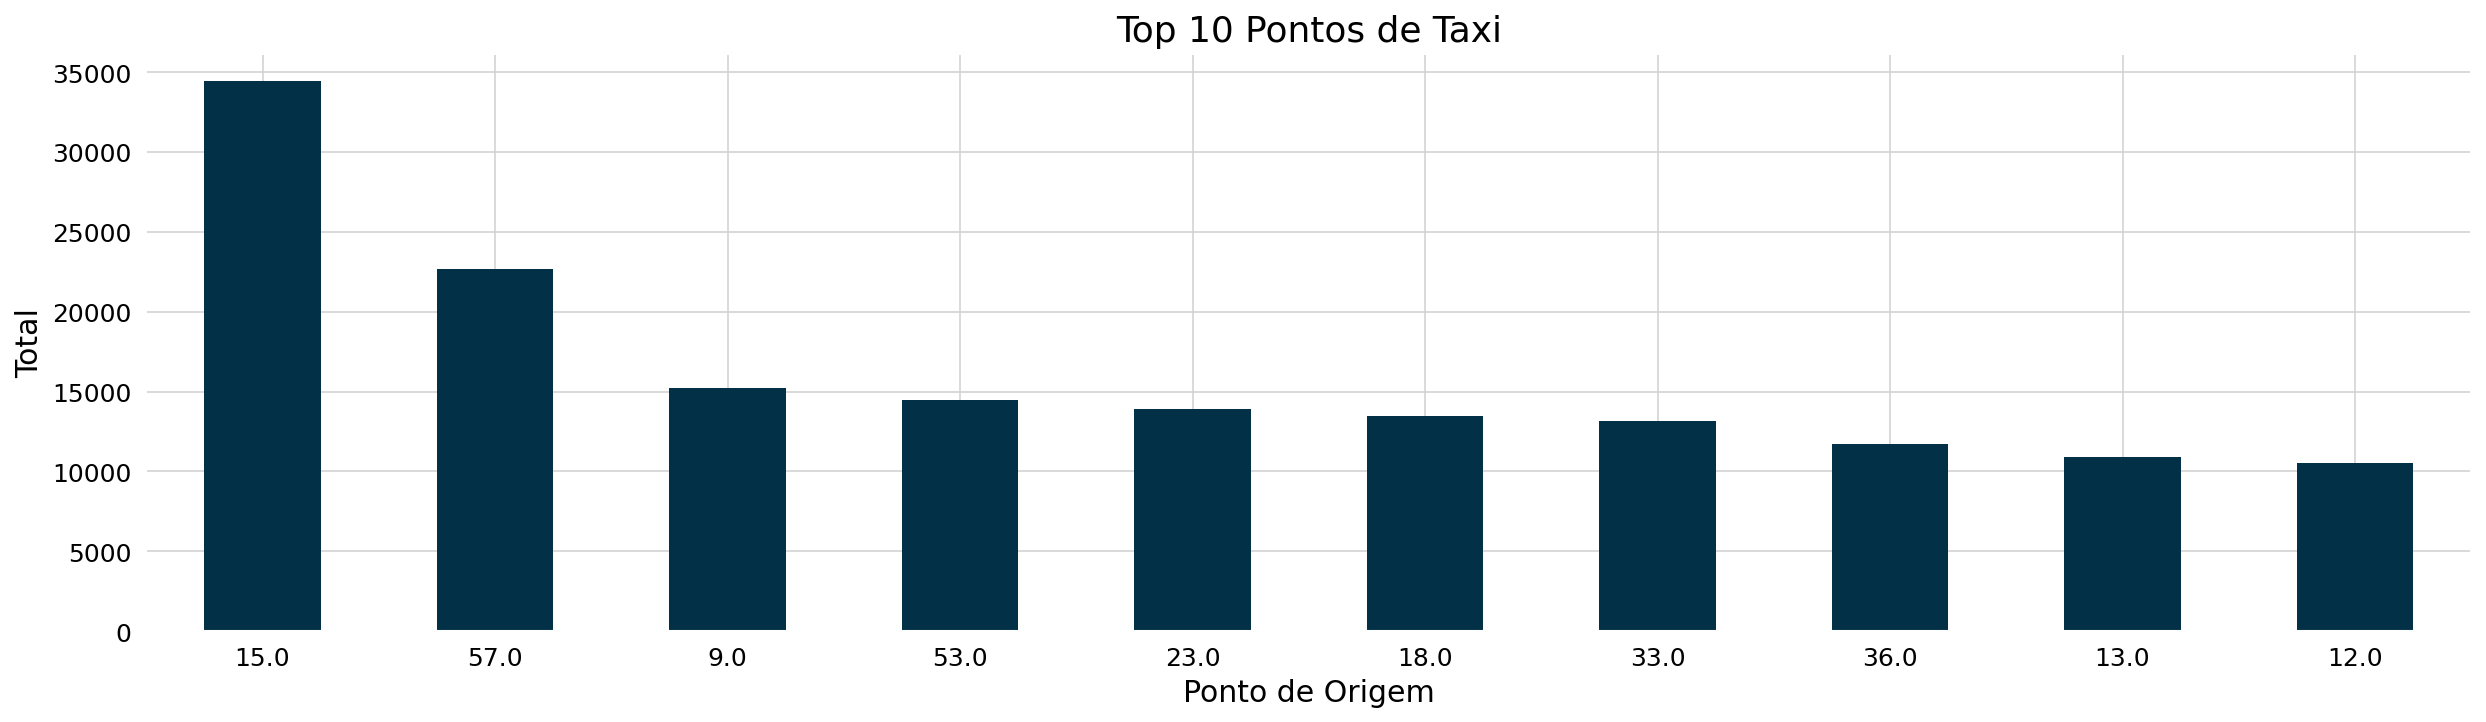

In [28]:
# Data manipulation
top_stands = df['origin_stand'].value_counts().dropna().head(10)

# Figure
fig_03 = top_stands.plot(kind='bar')

fig_03 = set_image(fig_03, 'Top 10 Pontos de Taxi', 'Ponto de Origem', 'Total');

- O ponto número 15 é o campeão em solicitações direto no Ponto;
- O ponto 15 tem mais que o dobro de solicitações do que o terceiro colocado.

### 3.4. Quais os taxistas com maior número de viagens?

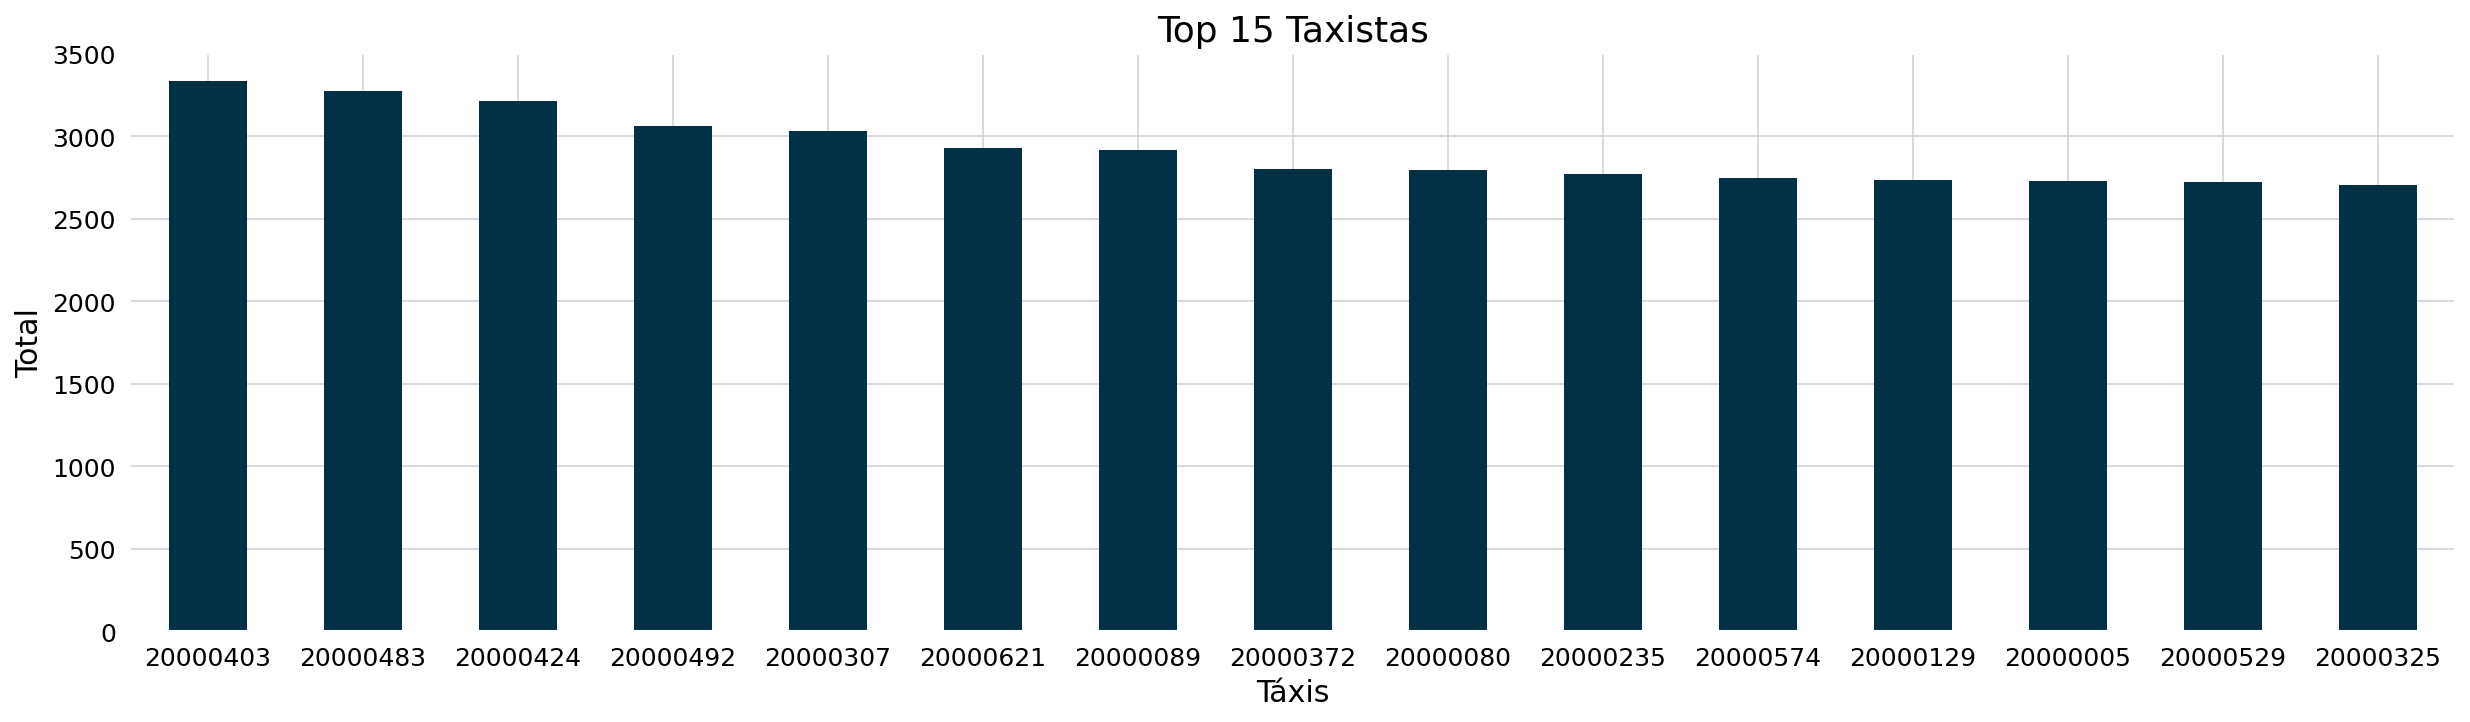

In [29]:
# Data manipulation
top_taxis = df['taxi_id'].value_counts().dropna().head(15)

# Figure 
fig_04 = top_taxis.plot(kind='bar')

# Customizing
fig_04 = set_image(fig_04, 'Top 15 Taxistas', 'Táxis', 'Total');

- Não há um taxista que se sobressaia em relação aos outros como no caso dos pontos de táxi.

### 3.5. Quais taxistas percorreram mais distância em suas viagens?

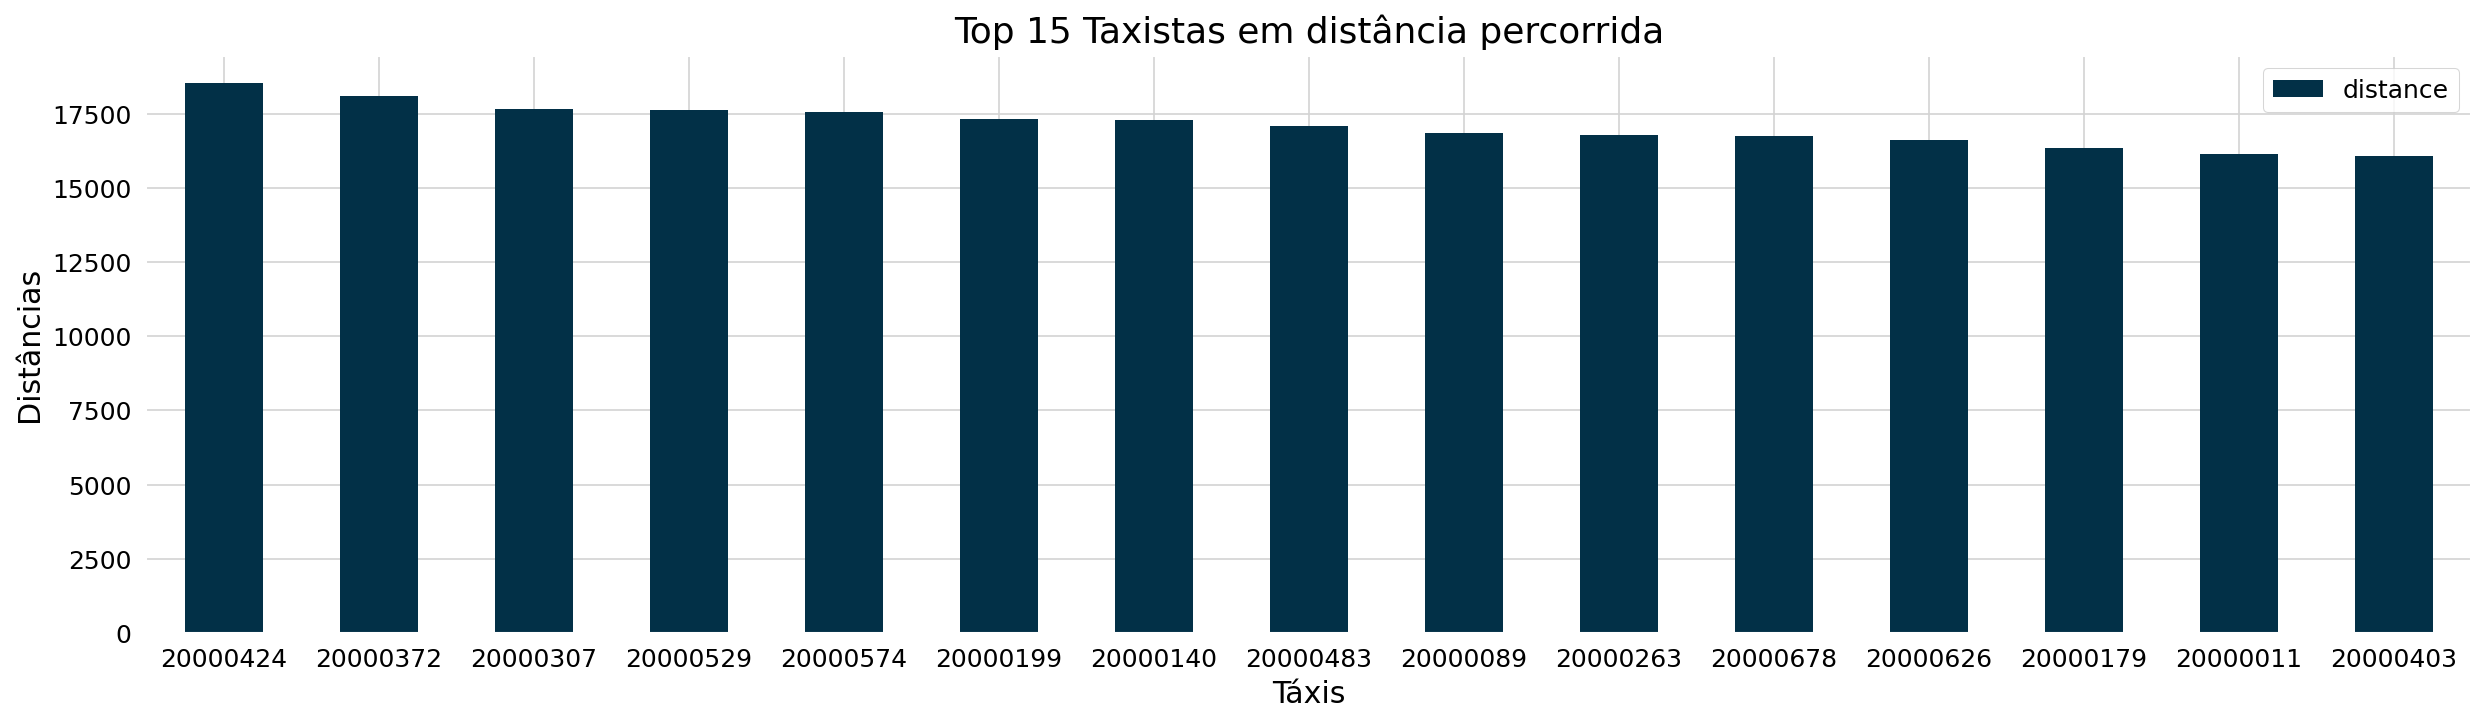

In [30]:
# Data manipulation
df_aux = df[['taxi_id', 'distance']].groupby(['taxi_id']).sum().reset_index()
df_aux = df_aux.sort_values(by='distance', ascending=False).head(15)

# Figure
fig_05 = df_aux.plot(kind='bar', x='taxi_id', y='distance')

fig_05 = set_image(fig_05, 'Top 15 Taxistas em distância percorrida', 'Táxis', 'Distâncias');

- Da mesma maneira, não existe um taxista que tenha percorrido muito mais distância em relação aos outros.

### 3.6. Qual a distribução das viagens por dia?

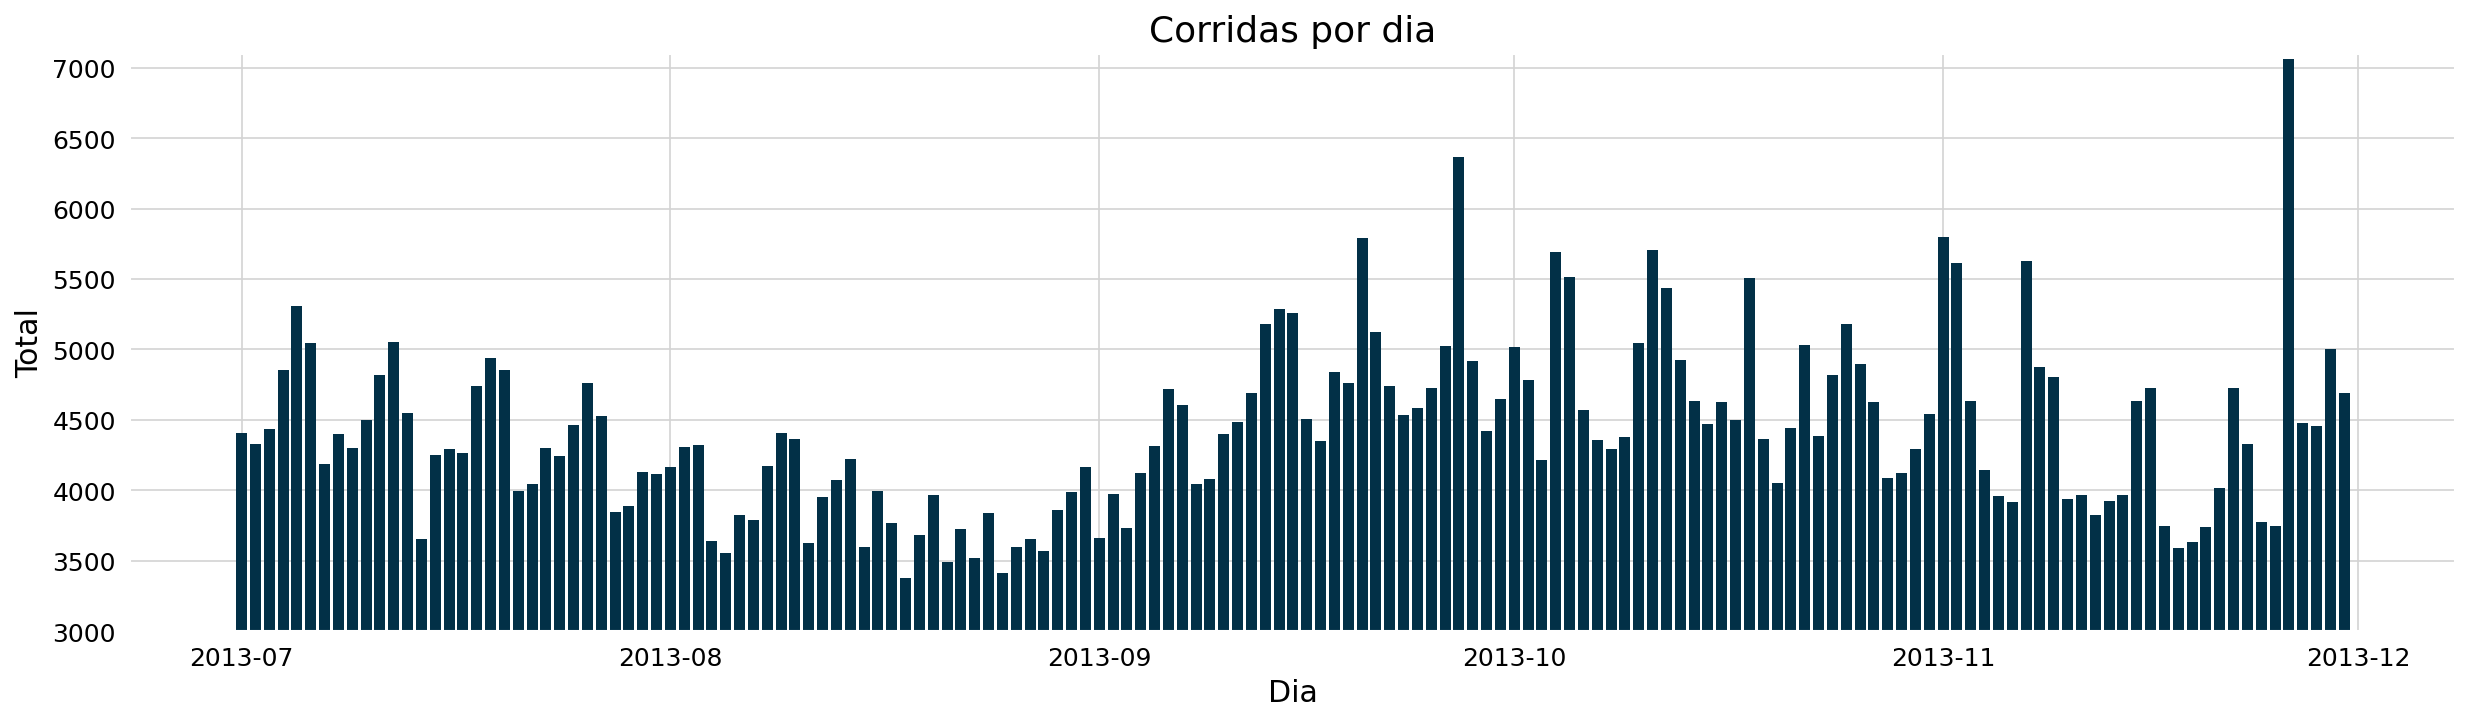

In [31]:
# Figure
fig_06 = plt.bar(df.day_month_year.value_counts().index, df.day_month_year.value_counts().values)

# Customizing
plt.ylim(3000, 7100)

fig_06 = set_image(fig_06, 'Corridas por dia', 'Dia', 'Total');

- É possível ver que as corridas acontecem em ondas pequenas de frequência;
- Agosto é um período com menos corridas por dia, provavelmente em razão do verão e pela cidade do Porto não ser um dos principais destinos nessa estação como o Algarve é.

### 3.7. Existe algum comportamento sazonal dentro dos meses?

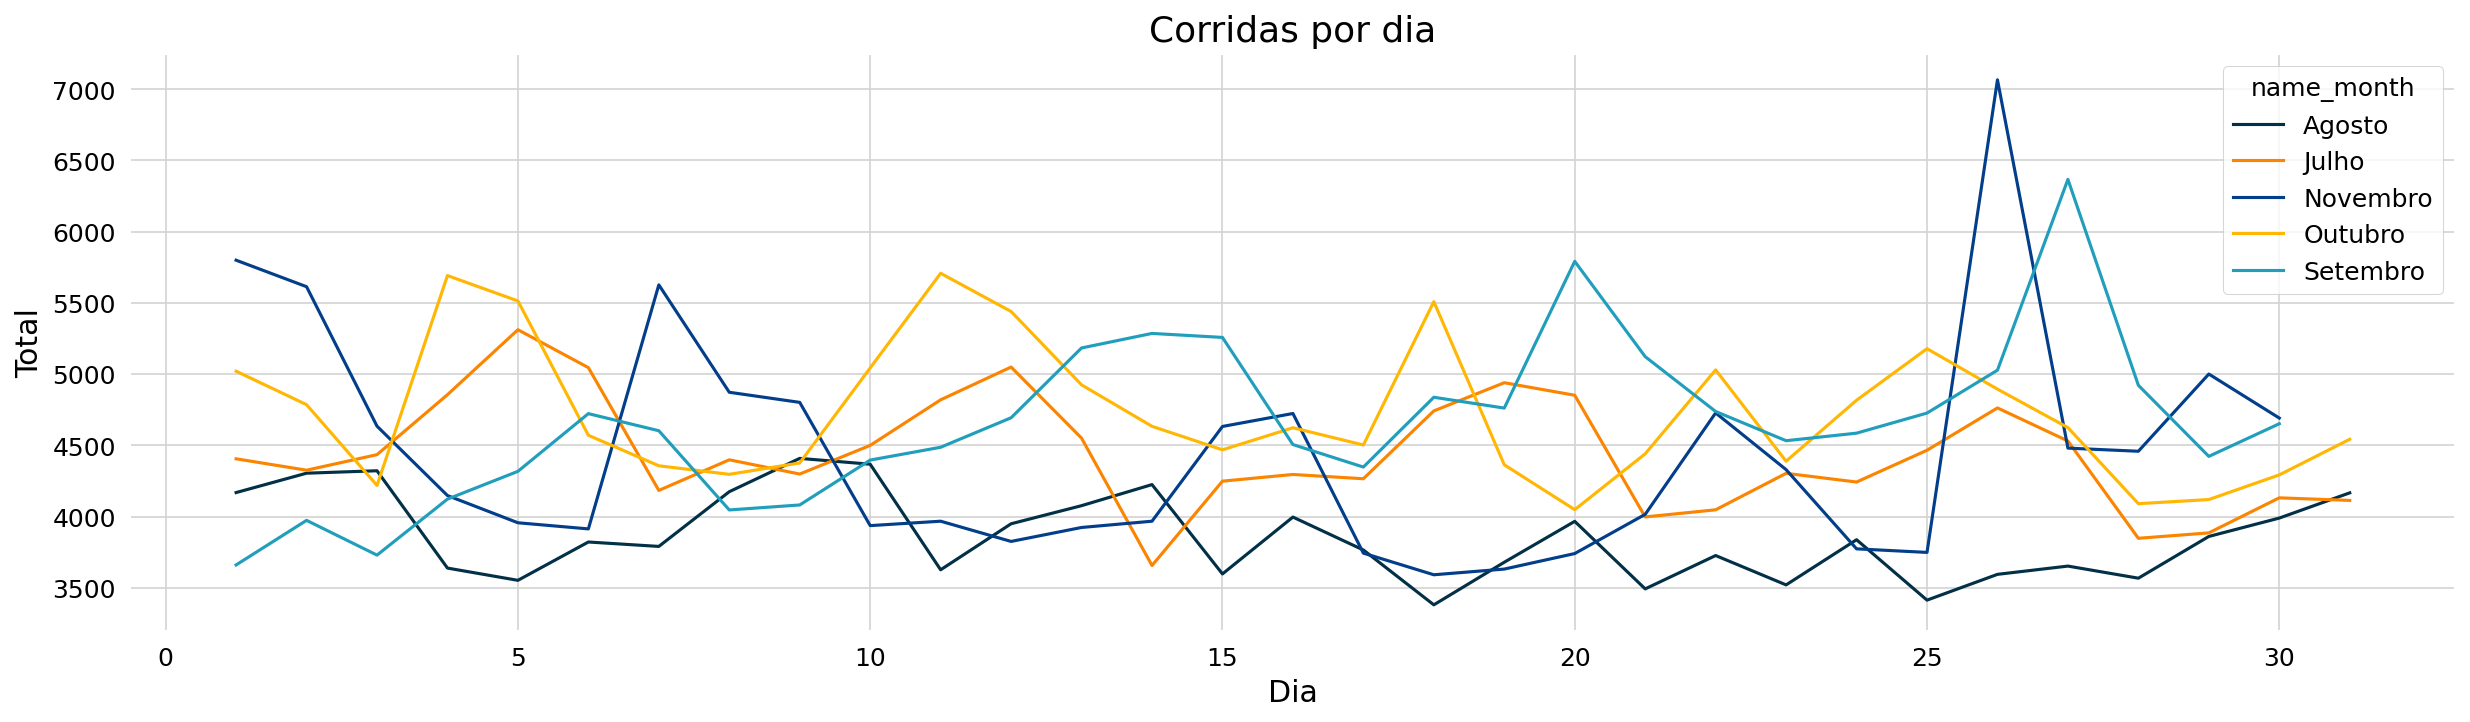

In [32]:
# Data manipulation
df_aux = df[['day', 'name_month', 'trip_id']].groupby(['day', 'name_month']).count().reset_index()

# Figure
fig_07 = sns.lineplot(data=df_aux, x='day', y='trip_id', hue='name_month')

# Customizg
fig_07 = set_image(fig_07, 'Corridas por dia', 'Dia', 'Total');

- As corridas por dia não apresentam um comportamento sazonal claro dentro dos meses de estudo.

### 3.8. Qual o dia da semana com mais corridas? Qual dia se percorre as maiores distâncias?

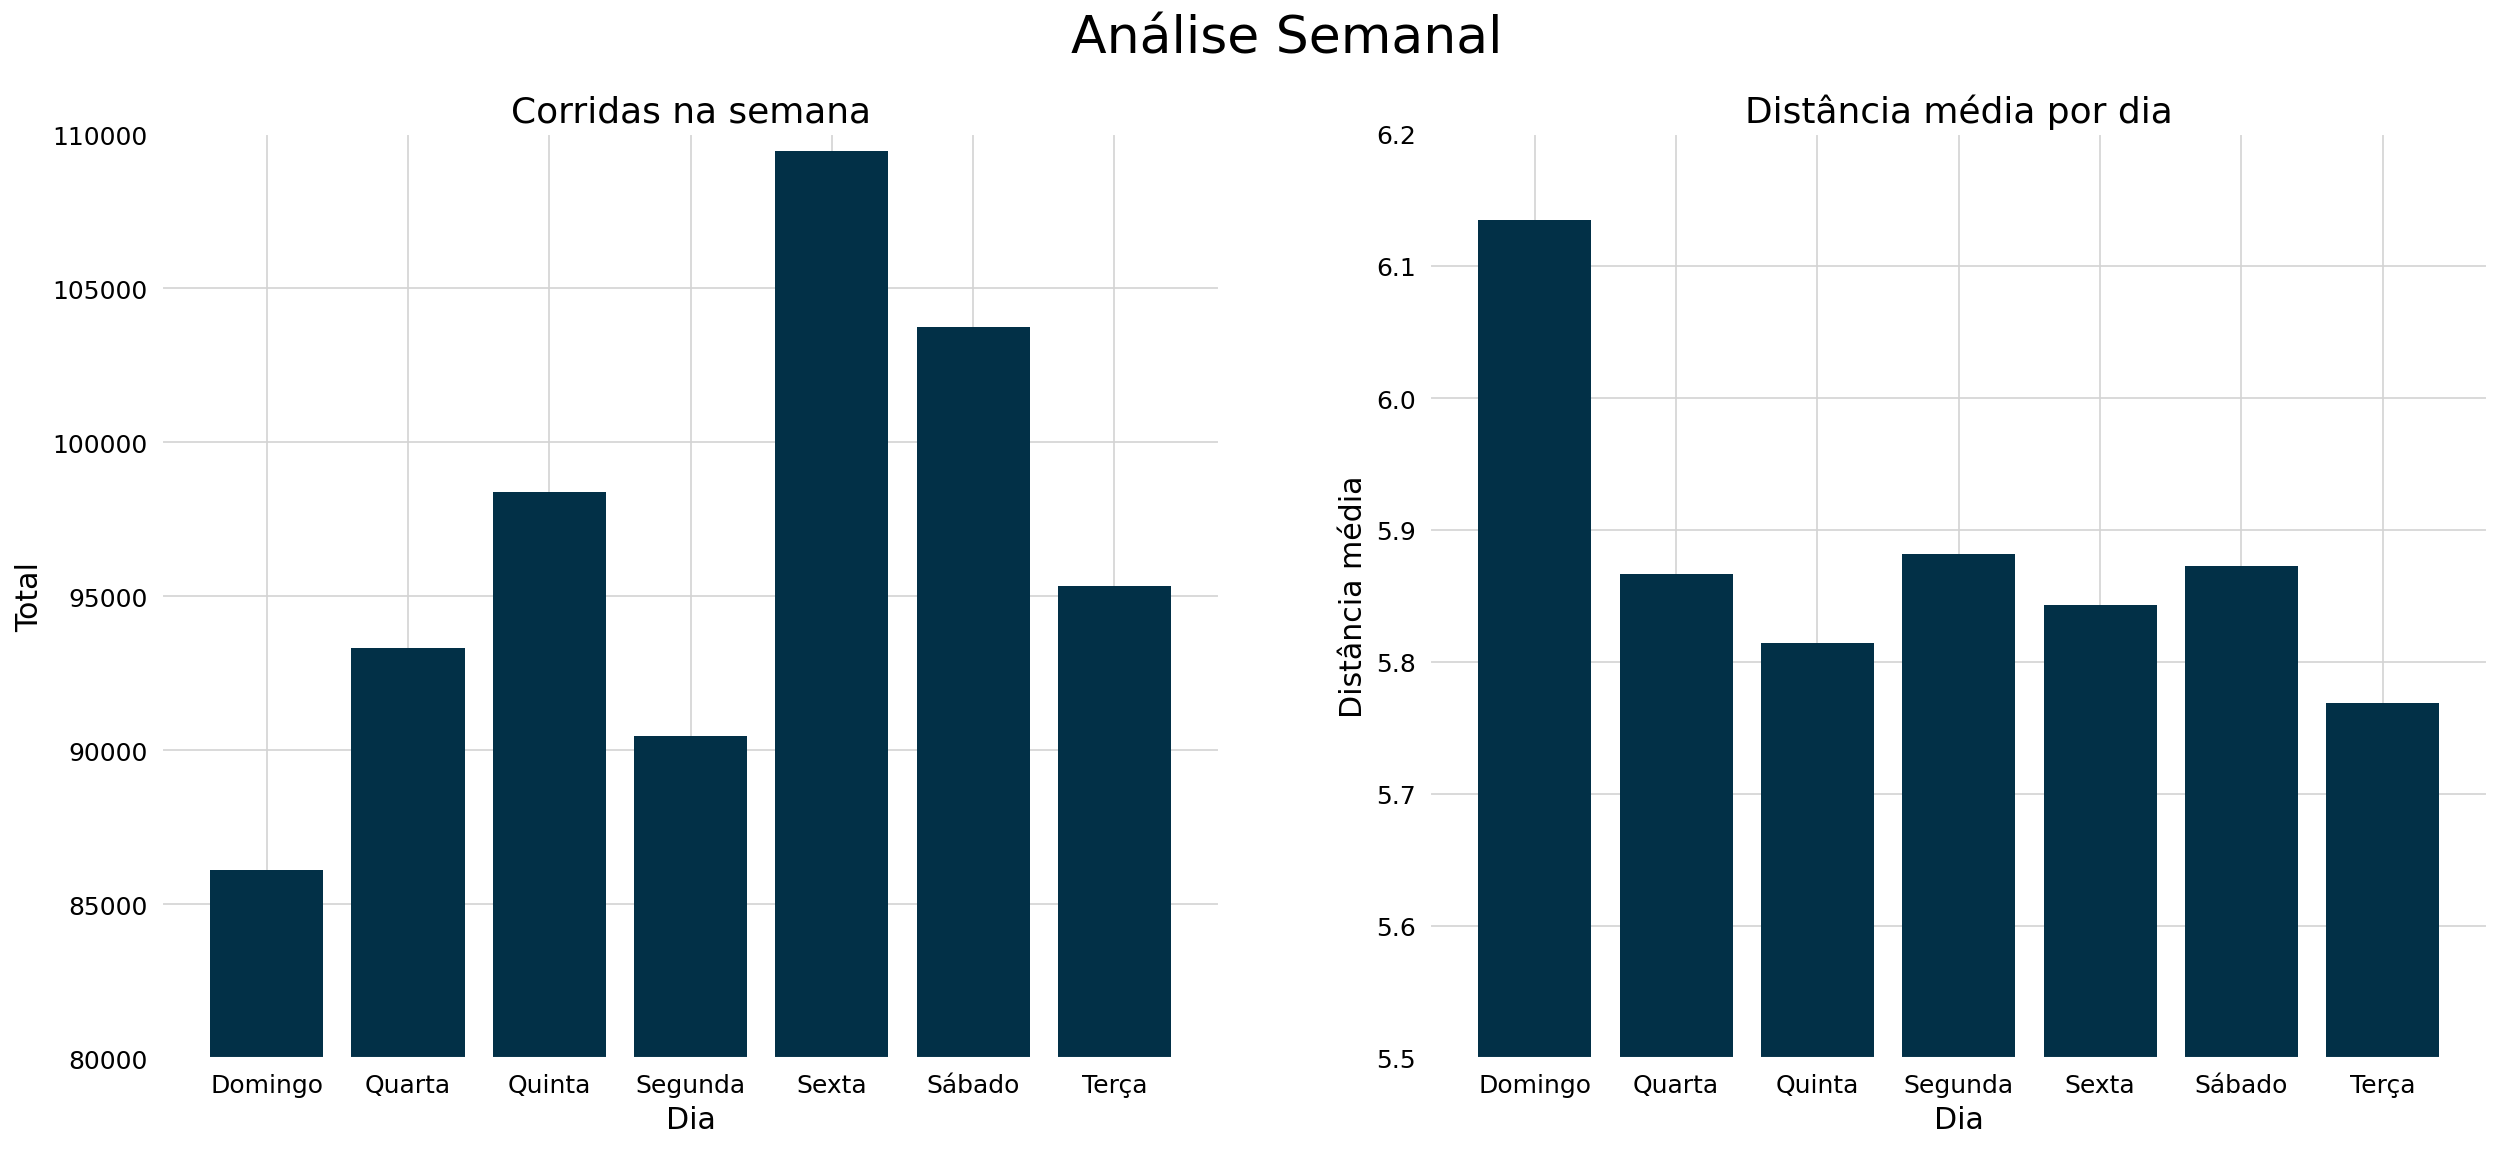

In [35]:
# Data Manipulation
df_aux1 = df[['name_dayofweek', 'trip_id']].groupby(['name_dayofweek']).count().reset_index()
df_aux2 = df[['name_dayofweek', 'distance']].groupby(['name_dayofweek']).mean().reset_index()

# Plot
fig_08, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1
plt.subplot(1, 2, 1)
ax1 = plt.bar(df_aux1.name_dayofweek, df_aux1.trip_id)

# Customizing plot 1
plt.ylim(80000, 110000)
ax1 = set_image(ax1, 'Corridas na semana', 'Dia', 'Total')

# Plot 2
plt.subplot(1, 2, 2)
ax2 = plt.bar(df_aux2.name_dayofweek, df_aux2.distance)

# Customizing plot 2
plt.ylim(5.5, 6.2)
ax2 = set_image(ax2, 'Distância média por dia', 'Dia', 'Distância média');

# Main title for plot
plt.suptitle('Análise Semanal')

# Adjusting space between plots
plt.subplots_adjust(hspace=0.35)

- O dia em que acontece mais viagens é a **sexta-feira**, seguida pelo **sábado** e pela **quinta-feira**;
- Por outro lado, os dias com menos corridas são **domingo** e **segunda-feira**;
- Interessantemente, **domingo** é de longe o dia em que se percorre as maiores distâncias médias;
- Os outros dias não apresentam muita diferência nas distâncias médias, mas a **segunda-feira** está em segundo lugar enquanto a **terça-feira** é o dia com menores distâncias percorridas;
- Este resultado vai de encontro com as "pequenas ondas" vistas no ponto 6 (corridas por dia), onde os dias com mais corridas estão no final da semana.

### 3.9. O comportamento das distâncias percorrida muda de acordo com o tipo de chamada?

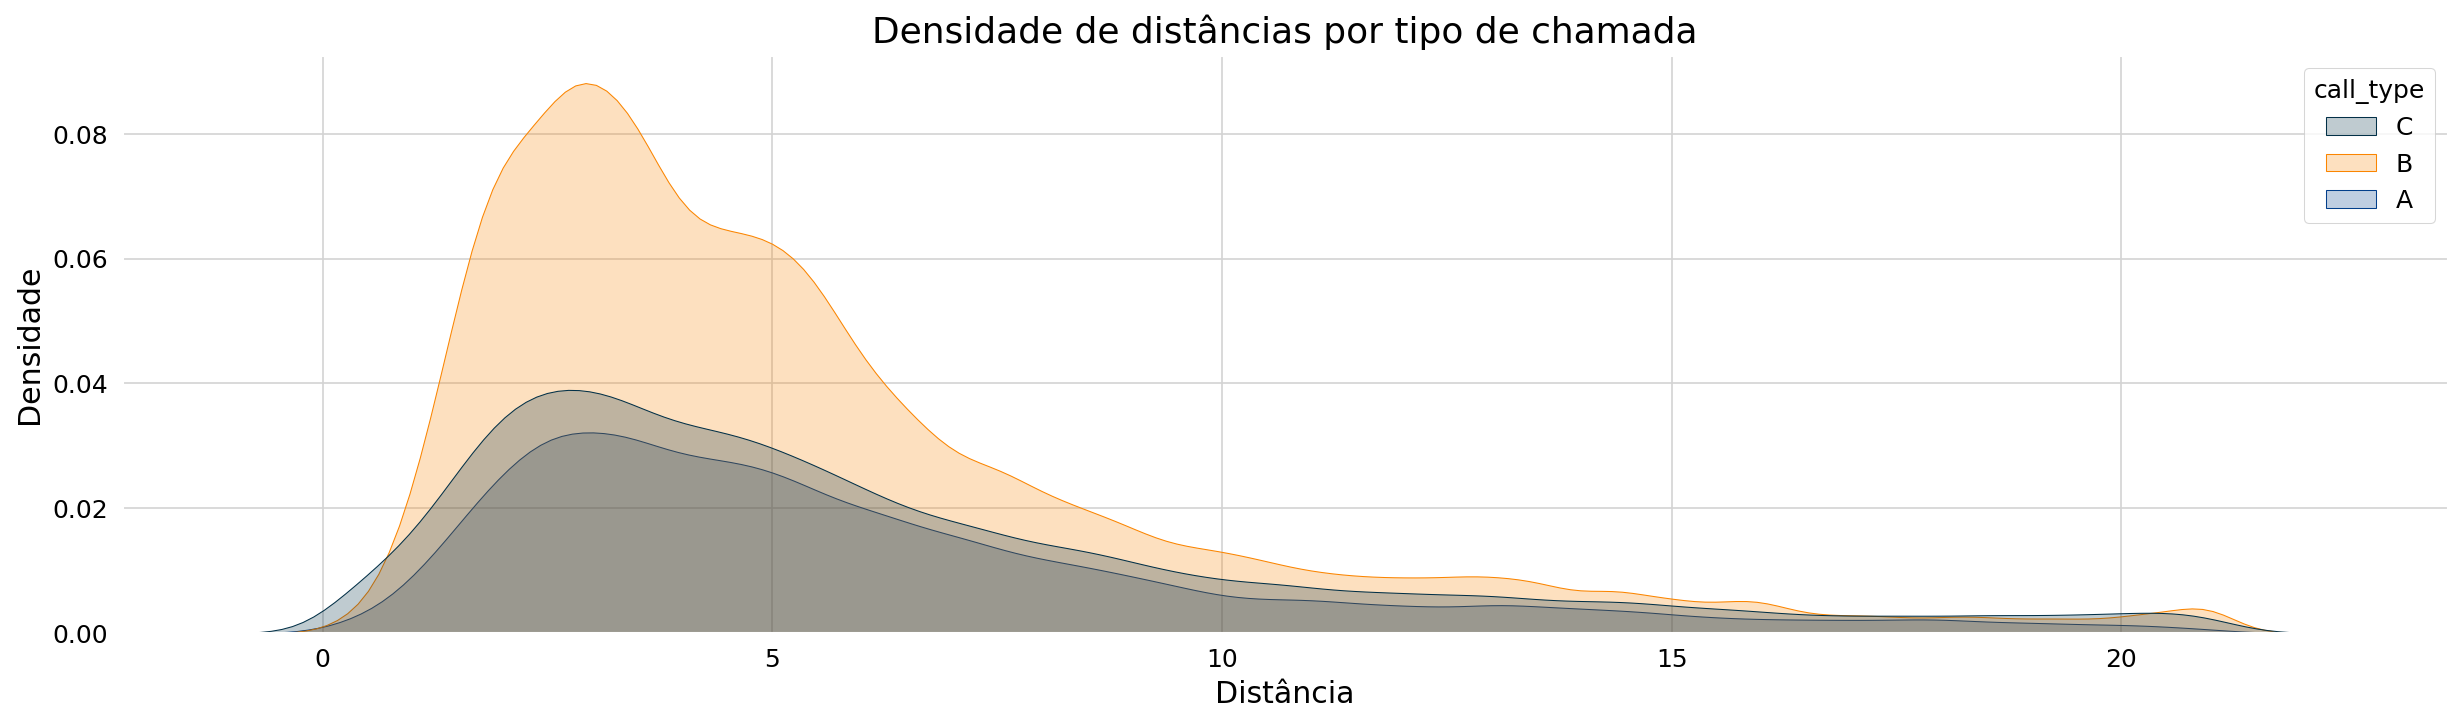

In [36]:
# Figure
fig_09 = sns.kdeplot(data=df, x='distance', hue='call_type', fill=True)

# Customizing
fig_09 = set_image(fig_09, 'Densidade de distâncias por tipo de chamada', 'Distância', 'Densidade');

- Existem mais corridas do tipo **B**, como já visto anteriormente, mas não aparenta existir uma relação com as distâncias percorridas.

### 3.10. Qual o comportamento das distâncias percorridas nas semanas do ano?

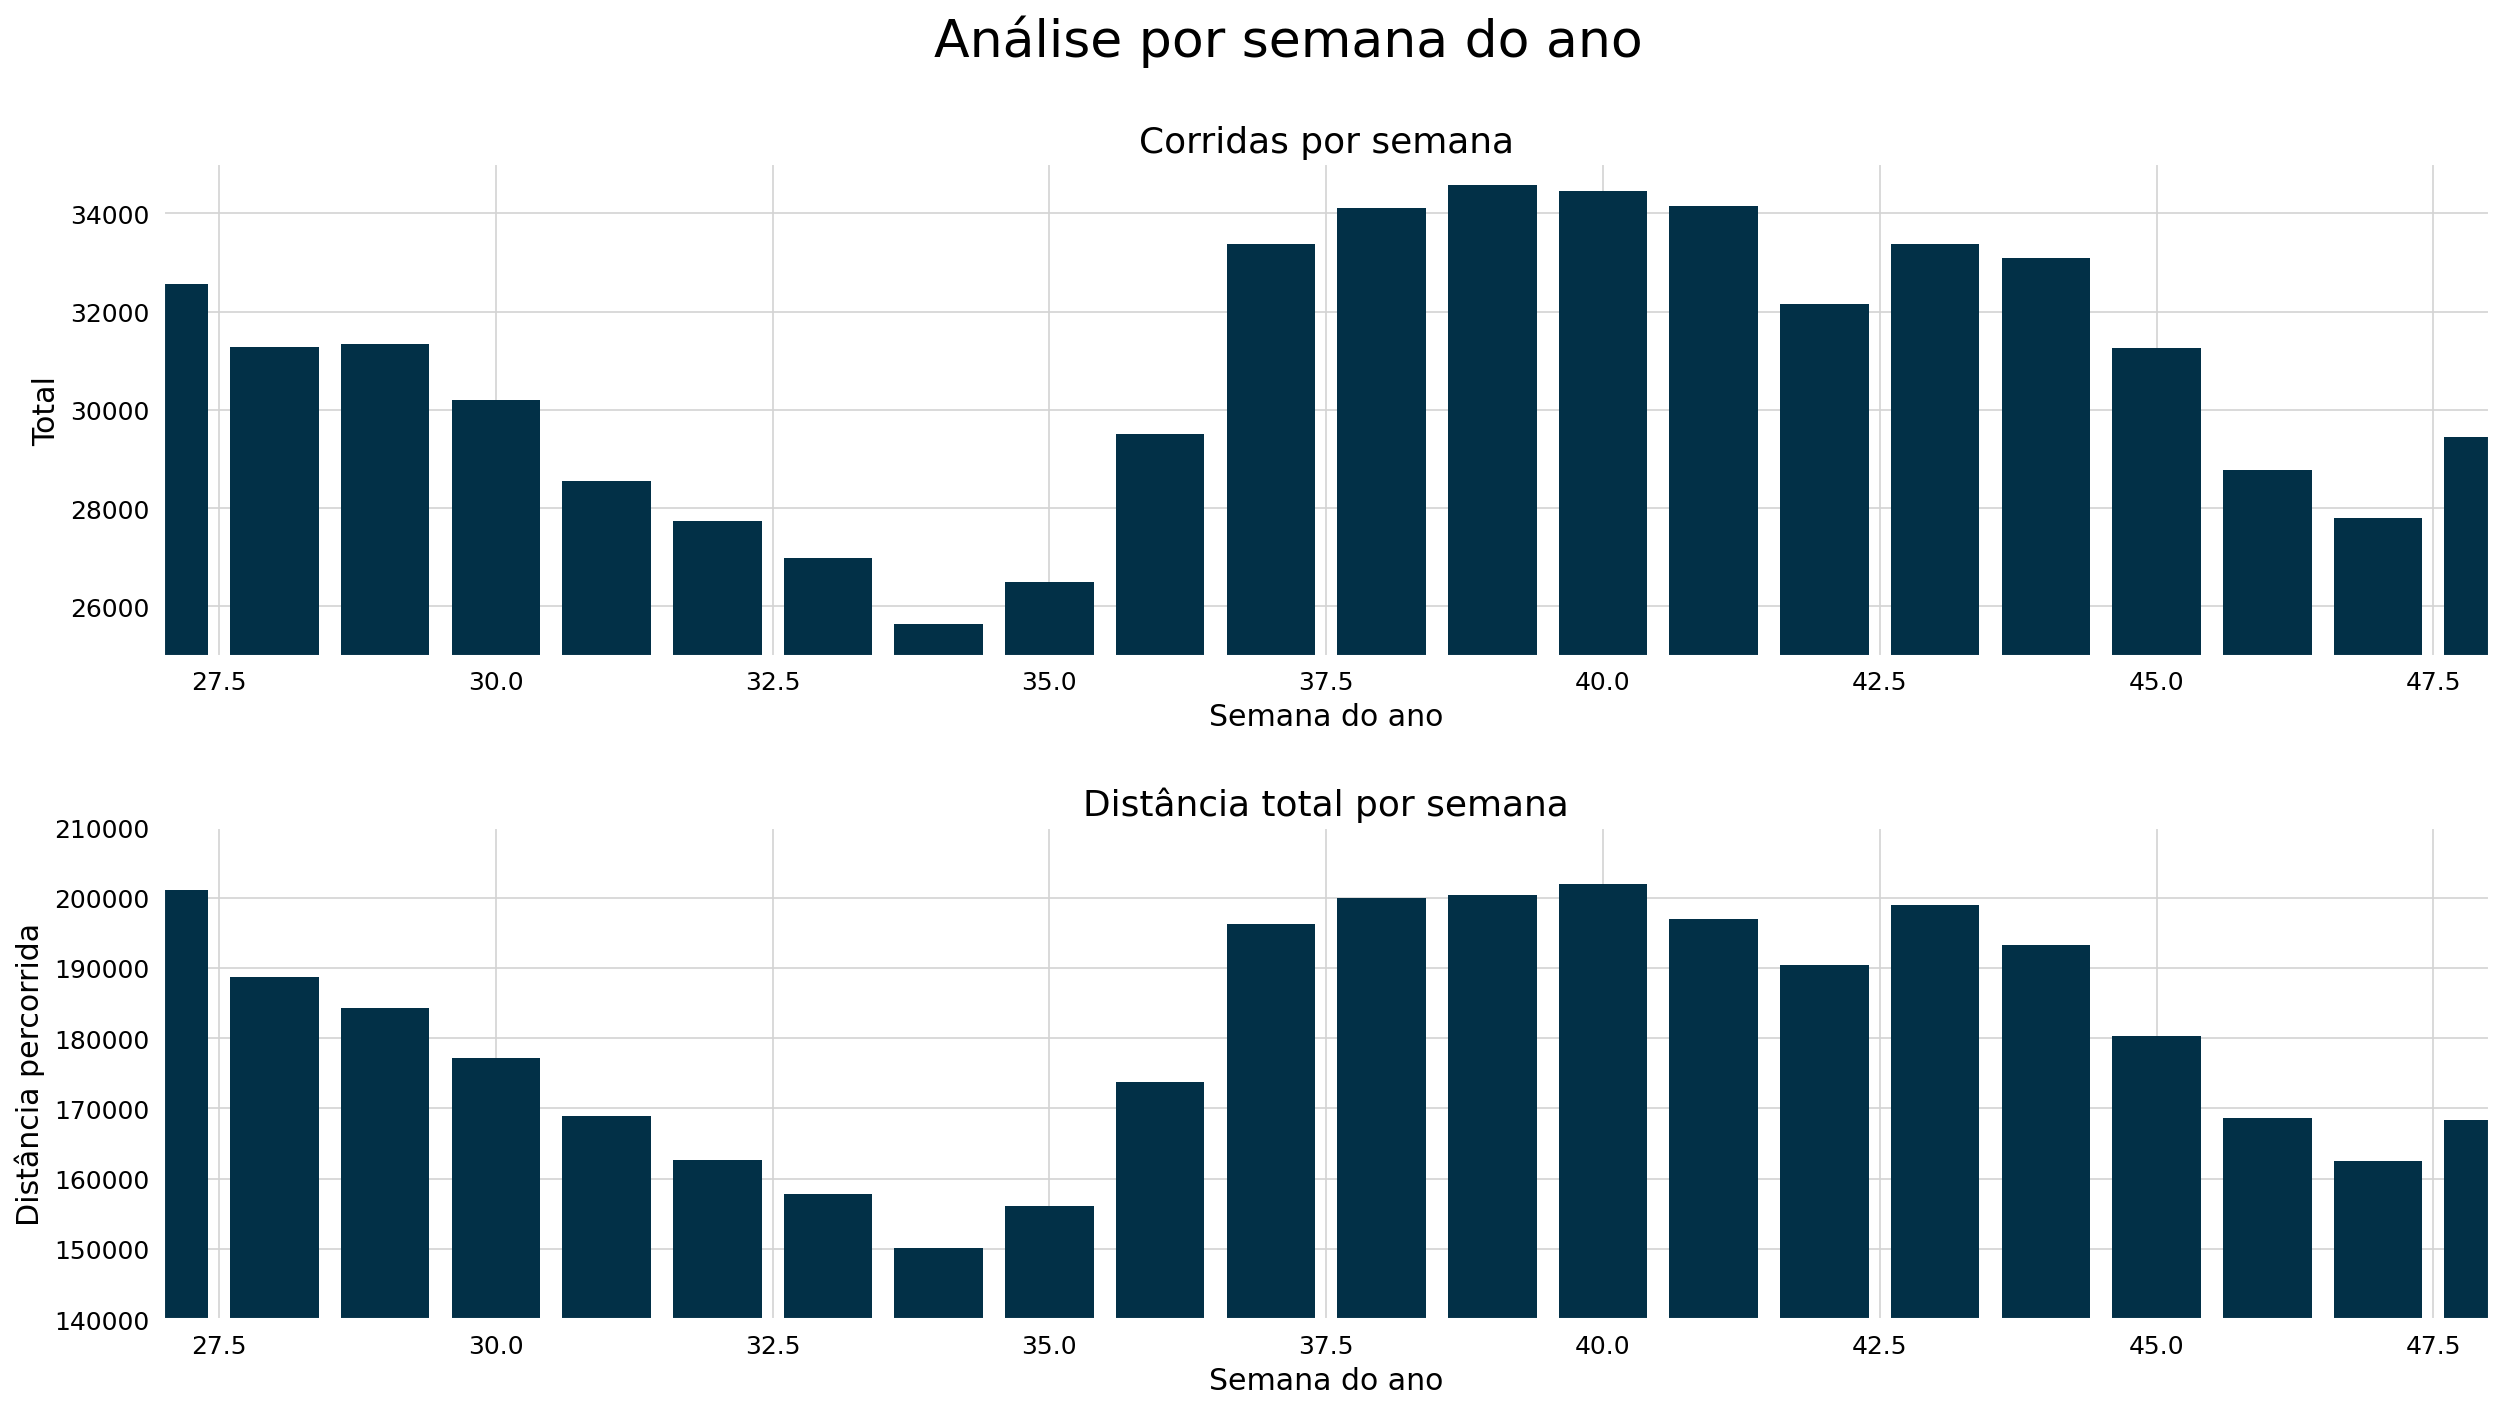

In [37]:
# Data Manipulation
df_aux1 = df[['weekofyear', 'distance']].groupby(['weekofyear']).count().reset_index()
df_aux2 = df[['weekofyear', 'distance']].groupby(['weekofyear']).sum().reset_index()

# Plot
fig_10, axes = plt.subplots(2, 1, figsize=(20, 10))

# Plot 1
plt.subplot(2, 1, 1)
ax1 = plt.bar(df_aux1.weekofyear, df_aux1.distance)

# Customizing plot 1
plt.ylim(25000, 35000)
plt.xlim(27,48)
ax1 = set_image(ax1, 'Corridas por semana', 'Semana do ano', 'Total')

# Plot 2
plt.subplot(2, 1, 2)
ax2 = plt.bar(df_aux2.weekofyear, df_aux2.distance)

# Customizing plot 2
plt.ylim(140000, 210000)
plt.xlim(27,48)
ax2 = set_image(ax2, 'Distância total por semana', 'Semana do ano', 'Distância percorrida');

# Main title for plot
plt.suptitle('Análise por semana do ano')

# Adjusting space between plots
plt.subplots_adjust(hspace=0.35)

- Como visto anteriormente, existe uma diminuição de viagens em Agosto, provavelmente em razão do verão na cidade, quando a população vai para destinos mais turísticos e apropriados.

### 3.11. Qual o comportamento das distâncias percorridas por mês?

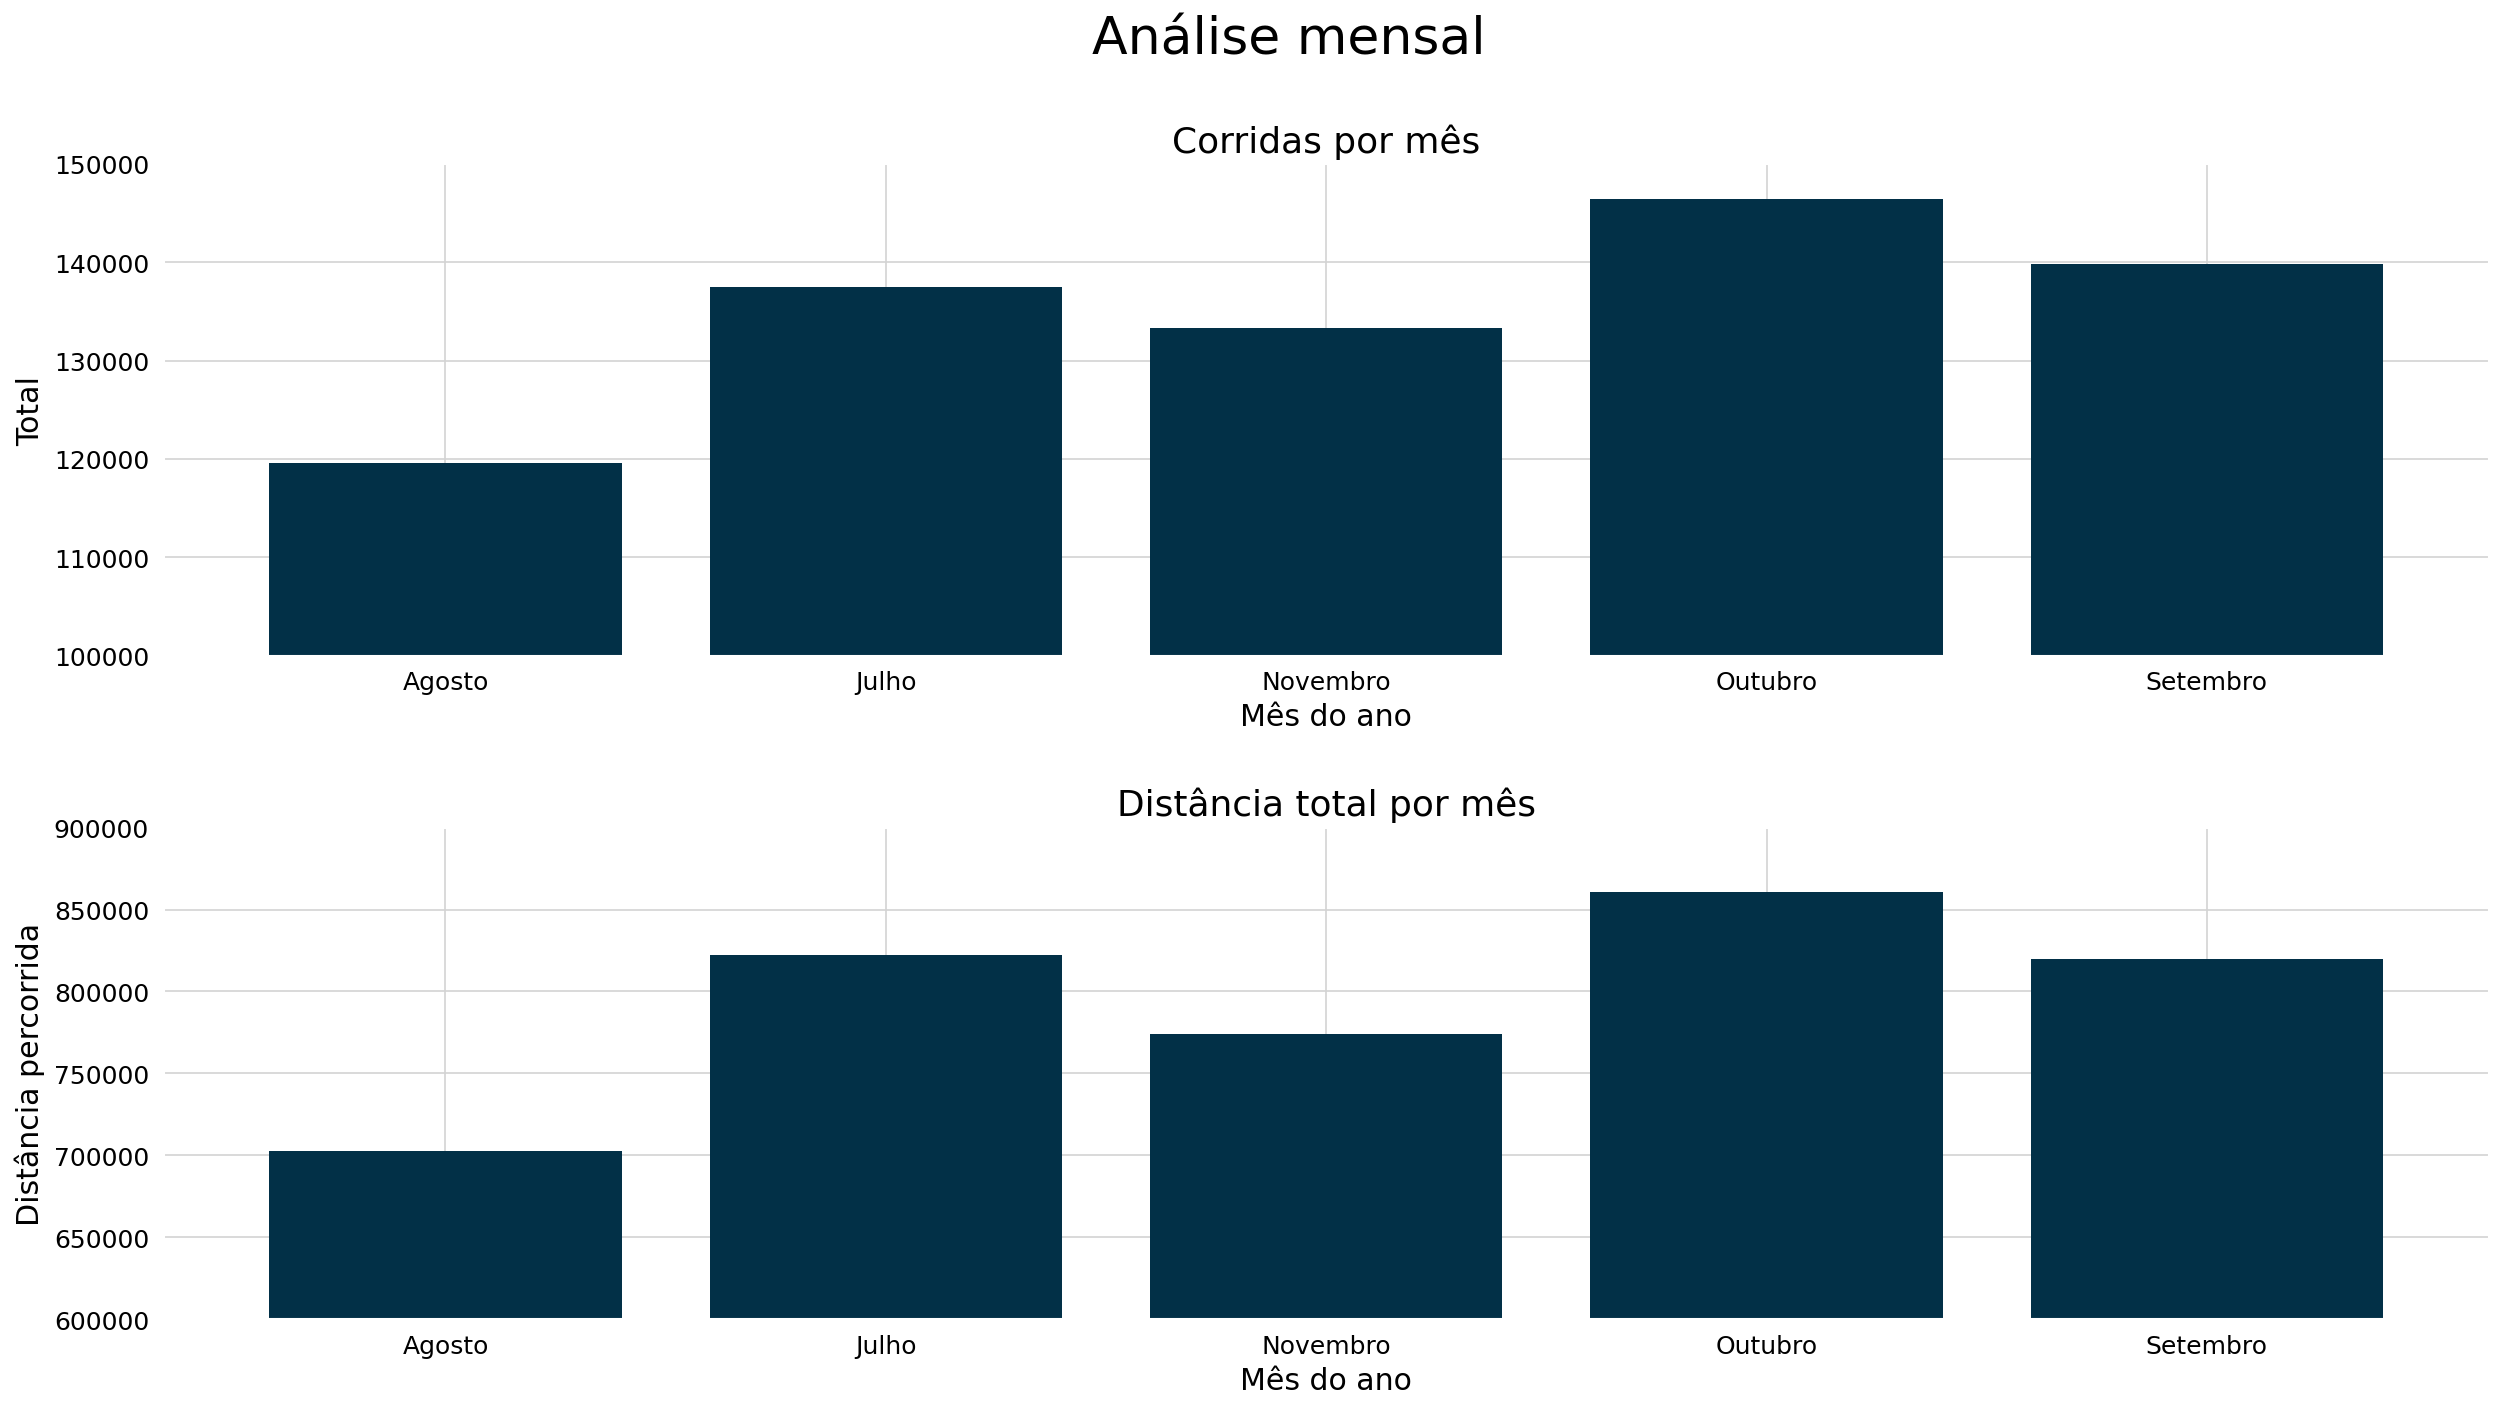

In [38]:
# Data Manipulation
df_aux1 = df[['name_month', 'distance']].groupby(['name_month']).count().reset_index()
df_aux2 = df[['name_month', 'distance']].groupby(['name_month']).sum().reset_index()

# Plot
fig_11, axes = plt.subplots(2, 1, figsize=(20, 10))

# Plot 1
plt.subplot(2, 1, 1)
ax1 = plt.bar(df_aux1.name_month, df_aux1.distance)

# Customizing plot 1
plt.ylim(100000, 150000)
ax1 = set_image(ax1, 'Corridas por mês', 'Mês do ano', 'Total')

# Plot 2
plt.subplot(2, 1, 2)
ax2 = plt.bar(df_aux2.name_month, df_aux2.distance)

# Customizing plot 2
plt.ylim(600000, 900000)
ax2 = set_image(ax2, 'Distância total por mês', 'Mês do ano', 'Distância percorrida');

# Main title for plot
plt.suptitle('Análise mensal')

# Adjusting space between plots
plt.subplots_adjust(hspace=0.35)

- Agosto, mês de verão em Portugal, é o mês com as menores distâncias totais e com menos corridas;
- Julho e Outubro de 2013 têm 23 dias úteis contra os 21 de Setembro e Novembro;
- O maior volume em Outubro também pode ser em consideração que Julho é outro mês do verão portugês.


### 3.12. Qual o comportamento das distâncias percorridas por hora do dia?

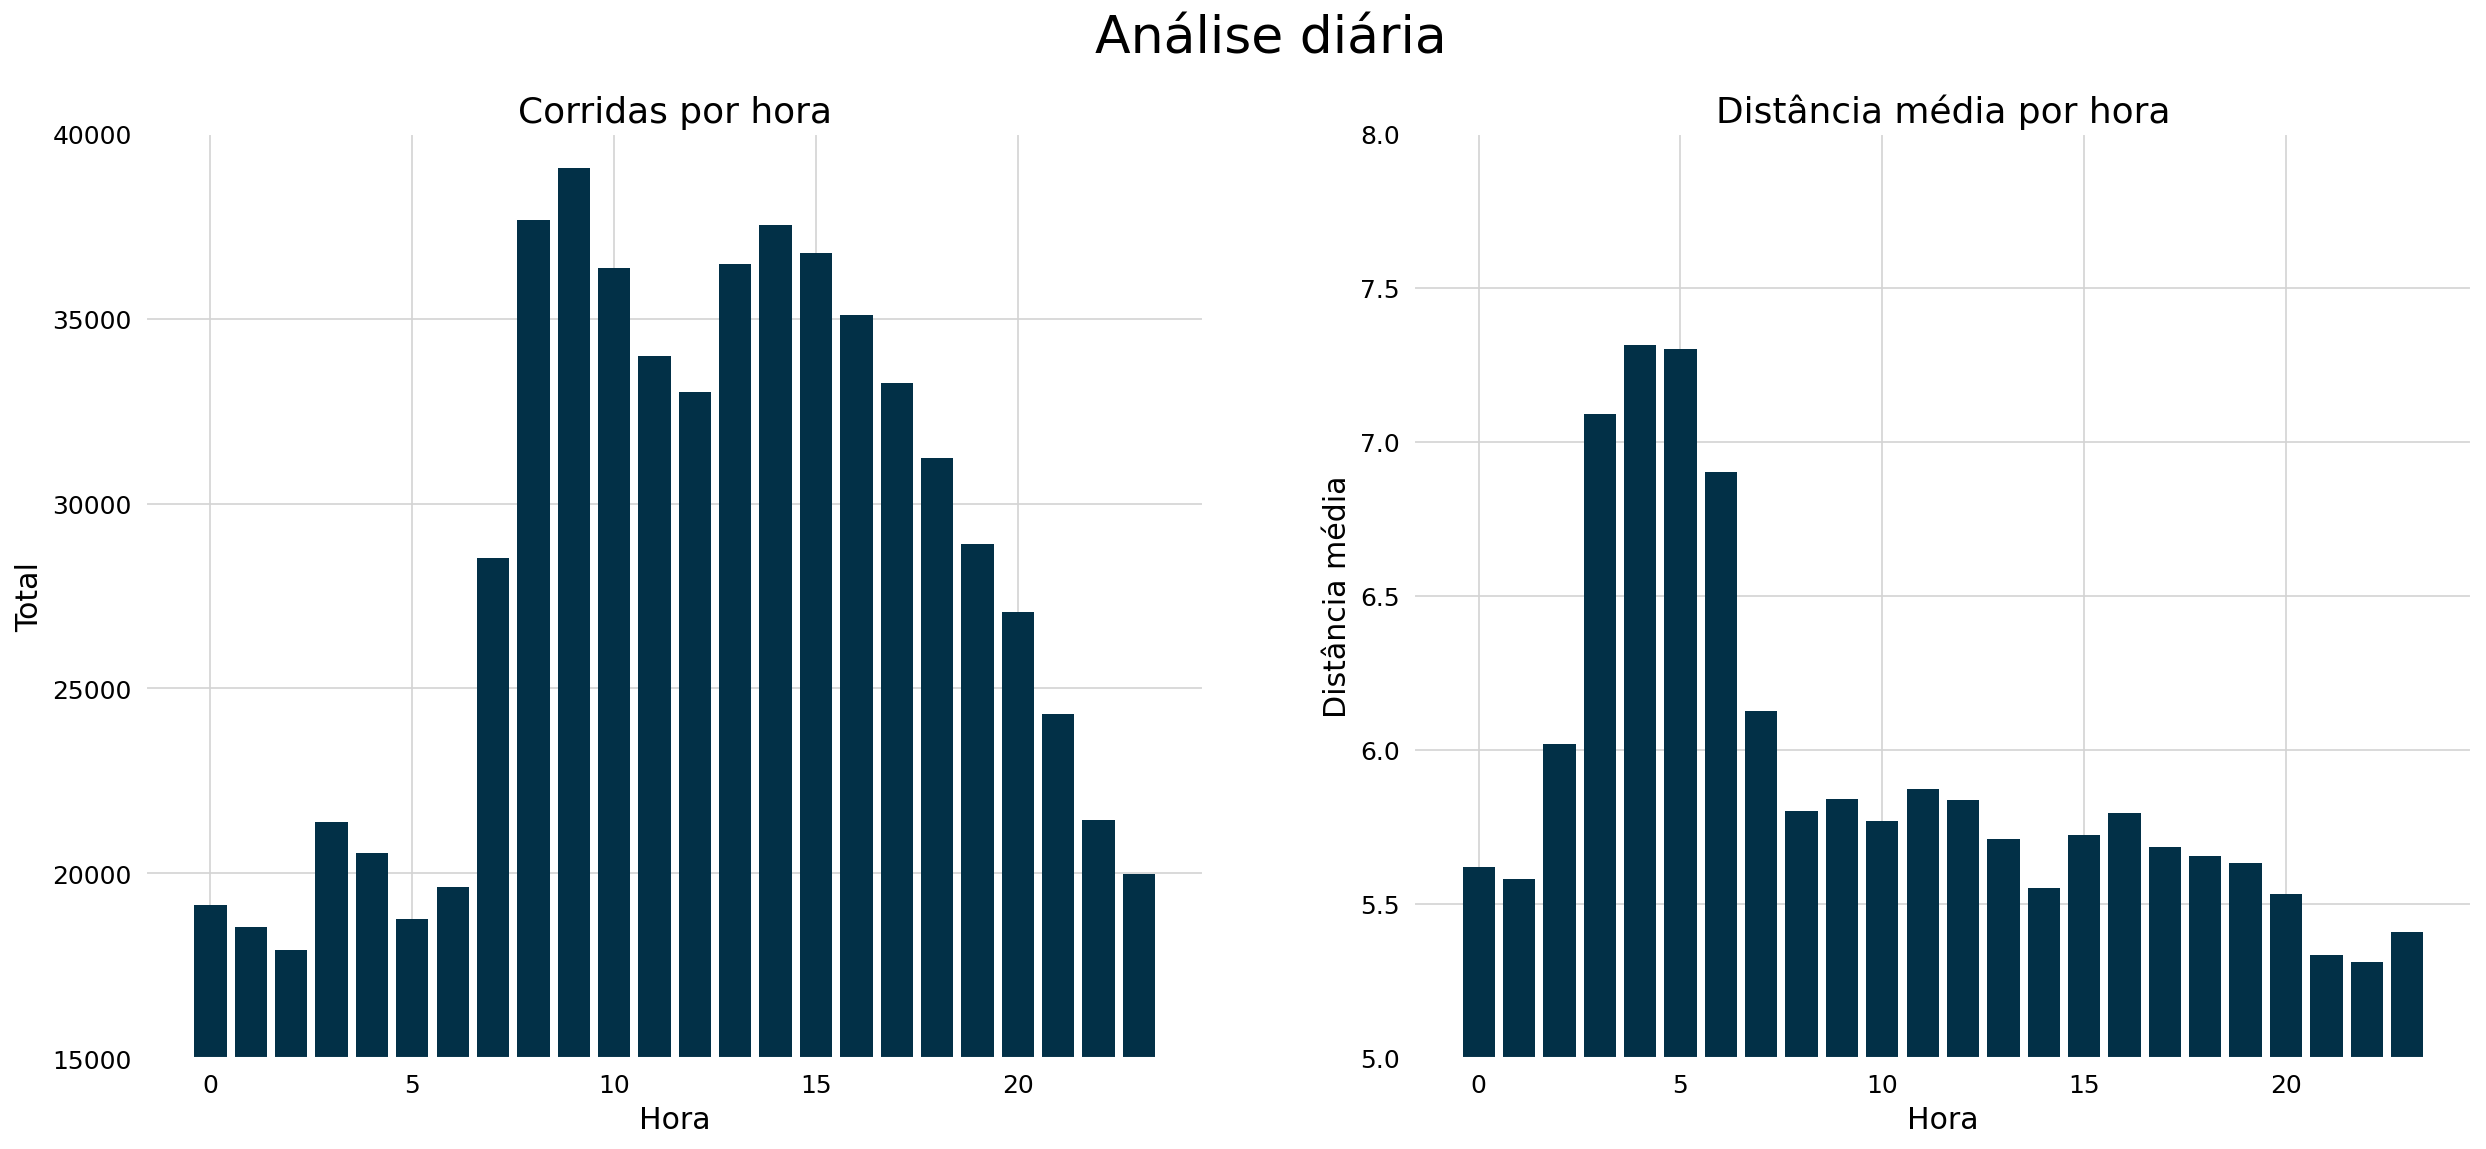

In [39]:
# Data Manipulation
df_aux1 = df[['hour', 'trip_id']].groupby(['hour']).count().reset_index()
df_aux2 = df[['hour', 'distance']].groupby(['hour']).mean().reset_index()

# Plot
fig_12, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1
plt.subplot(1, 2, 1)
ax1 = plt.bar(df_aux1.hour, df_aux1.trip_id)

# Customizing plot 1
plt.ylim(15000, 40000)
ax1 = set_image(ax1, 'Corridas por hora', 'Hora', 'Total')

# Plot 2
plt.subplot(1, 2, 2)
ax2 = plt.bar(df_aux2.hour, df_aux2.distance)

# Customizing plot 2
plt.ylim(5, 8)
ax2 = set_image(ax2, 'Distância média por hora', 'Hora', 'Distância média');

# Main title for plot
plt.suptitle('Análise diária')

# Adjusting space between plots
plt.subplots_adjust(hspace=0.35)

- O maior volume de corridas acontece entre às 8h e às 10h da manhã, com uma diminuição no horário de almoço e retomada de um forte volume das 13h às 15h;
- A menor quantidade de corridas é realizada na madrugada, entre às 0h e às 6h;
- Por outro lado, as maiores distâncias médias percorridas estão nessa faixa de horário, mais precisamente das 3h às 6h;
- No resto do dia, as distâncias médias não oscilam tanto.

## 4. Feature Engineering and Data Preparation

### 4.1. Criando novas variáveis

In [40]:
# Creating initial position latitude and longitude from polyline coordinates
df['init_lat'] = df['polyline'].apply(lambda x: x[0][1] if x else None)
df['init_lon'] = df['polyline'].apply(lambda x: x[0][0] if x else None)

# Creating last position latitude and longitude from polyline coordinates
df['last_lat'] = df['polyline'].apply(lambda x: x[-1][1] if x else None)
df['last_lon'] = df['polyline'].apply(lambda x: x[-1][0] if x else None)


### 4.2. Excluindo colunas desnecesárias para o modelo

In [41]:
df = df.drop(columns=['trip_id', 'day_type', 'taxi_id', 'timestamp', 'polyline', 'missing_data', 'name_dayofweek', 'name_month', 'weekofyear', 'day_month_year'])

#### Excluindo Colunas 

- `trip_id`: um identificador único para cada corrida não influencia no modelo;
- `day_type`: todos os valores da coluna são iguais a "A";
- `taxi_id`: o identificador único de um táxi não influencia no ponto final de chegada da corrida;
- `timestamp`: datetime feature
- `polyline`: o trajeto é um resultado final de cada corrida, de maneira que os trajetos passados não são relevantes para prever o ponto final de uma corrida futura;
- `missing_data`: todos os valores da coluna são iguais a "False";
- `name_dayofweek`: object feature;
- `name_month`: object feature;
- `weekofyear`: não é relevante para prever corridas em semanas que ainda não aconteceram;
- `day_month_year`: datetime feature.

### 4.3. Encoding

#### 4.3.1. Encoding `call_type`

In [42]:
df = pd.get_dummies(df, columns=['call_type'], prefix='call_type')

### 4.4. Tratando valores faltantes

#### 4.4.1. Coluna `origin_call`

In [43]:
df['origin_call'] = df['origin_call'].fillna(0).astype(int)

#### 4.4.2. Coluna `origin_stand`

In [44]:
df['origin_stand'] = df['origin_stand'].fillna(0).astype(int)

### 4.5. Utilizando uma amostra dos dados

In [45]:
df_sample = df.sample(n=250000, random_state=SEED)

### 4.6. Train-Test Split

In [46]:
# Definindo variáveis de modelagem e alvo
X = df_sample.drop(columns=['last_lat', 'last_lon'])
y_lat = df_sample['last_lat']
y_lon = df_sample['last_lon']

# Split
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(X, y_lat, y_lon, test_size=0.2, random_state=SEED)

## 5. Machine Learning

- Considerando que se trata de um grande dataset, o modelo escolhido para prever os pontos finais das corridas é o LightGBM;
- LightGBM é reconhecido pela sua boa performance, rapidez com grandes datasets e eficiência de memória computacional.

### 5.1. LightGBM

#### 5.1.1. Modelo

In [47]:
# Latitude
lgb_model_lat = lgb.LGBMRegressor()
lgb_model_lat.fit(X_train, y_lat_train)

# Longitude
lgb_model_lon = lgb.LGBMRegressor()
lgb_model_lon.fit(X_train, y_lon_train)

LGBMRegressor()

#### 5.1.2. Predicting

In [48]:
y_lat_pred = lgb_model_lat.predict(X_test)
y_lon_pred = lgb_model_lon.predict(X_test)

#### 5.1.3. Evaluating

In [49]:
mse_lat = mean_squared_error(y_lat_test, y_lat_pred)
mae_lat = mean_absolute_error(y_lat_test, y_lat_pred)
mse_lon = mean_squared_error(y_lon_test, y_lon_pred)
mae_lon = mean_absolute_error(y_lon_test, y_lon_pred)

print(f'Mean Squared Error (Latitude):  {mse_lat: .5f}')
print(f'Mean Absolute Error (Latitude): {mae_lat: .5f}')
print(f'Mean Squared Error (Longitude): {mse_lon: .5f}')
print(f'Mean Absolute Error (Longitude): {mae_lon: .5f}')

Mean Squared Error (Latitude):   0.00036
Mean Absolute Error (Latitude):  0.01227
Mean Squared Error (Longitude):  0.00067
Mean Absolute Error (Longitude):  0.01880


Mean Squared Error (Latitude):  0.00036
Mean Absolute Error (Latitude):  0.01227
Mean Squared Error (Longitude):  0.00067
Mean Absolute Error (Longitude):  0.01880

- **MSE** é uma medida da diferença **quadrática média** entre os valores previstos e reais. Quanto mais próxima de zero, melhor.
- **MAE** é uma medida da diferença **média absoluta** entre os valores previstos e reais, ou seja, está na mesma unidade que as variáveis alvo. Da mesma forma que MSE, o resultado é melhor quanto mais próximo de zero.

### 5.2. Hyperparameter Tuning

In [50]:
# Criando Grid de hiperparametros
param_grid = {
    'n_estimators':     [250, 500, 750],
    'learning_rate':    [0.01, 0.05, 0.1],
    'max_depth':        [5, 7, 10]}

# Modelos
lgb_model_lat       = lgb.LGBMRegressor()
grid_search_lat     = GridSearchCV(estimator=lgb_model_lat, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search_lat.fit(X_train, y_lat_train)

lgb_model_lon       = lgb.LGBMRegressor()
grid_search_lon     = GridSearchCV(estimator=lgb_model_lon, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search_lon.fit(X_train, y_lon_train)

# Predictions
y_lat_pred = grid_search_lat.predict(X_test)
y_lon_pred = grid_search_lon.predict(X_test)

# Evaluating
mse_lat = mean_squared_error(y_lat_test, y_lat_pred)
mae_lat = mean_absolute_error(y_lat_test, y_lat_pred)
mse_lon = mean_squared_error(y_lon_test, y_lon_pred)
mae_lon = mean_absolute_error(y_lon_test, y_lon_pred)

print(f'Mean Squared Error (Latitude):  {mse_lat: .5f}')
print(f'Mean Absolute Error (Latitude): {mae_lat: .5f}')
print(f'Mean Squared Error (Longitude): {mse_lon: .5f}')
print(f'Mean Absolute Error (Longitude): {mae_lon: .5f}')

Mean Squared Error (Latitude):   0.00035
Mean Absolute Error (Latitude):  0.01192
Mean Squared Error (Longitude):  0.00065
Mean Absolute Error (Longitude):  0.01828


Mean Squared Error (Latitude):  0.00035
Mean Absolute Error (Latitude):  0.01192
Mean Squared Error (Longitude):  0.00065
Mean Absolute Error (Longitude):  0.01828

### 5.3. Avaliação

- O modelo com hiperparametros otimizados não se demonstrou muito melhor do que os resultados obtidos anteriormente;
- Em média, as diferenças quadradas de latitude e longitude entre os valores previstos e reais são baixas (0.00035 e 0.00065, respectivamente);

**Latitude**

- A diferença (range) de **latitudes** no dataset é de 3.36, enquanto que a distância interquartis (Q3 - Q1) é de 0.0210, ou seja, onde 50% dos dados estão;
- O resultado do MAE de 0.01192 é bem pequeno, especialmente quando comparado à variação total (< 1%);
- Em geral, o modelo da **latitude** está prevendo bem pois é praticamente a metade da variação interquartil;

**Longitude**

- A diferença (range) de **longitudes** no dataset é de 2.16, enquanto que a distância interquartis (Q3 - Q1) é de 0.0367;
- O resultado do MAE de 0.01828 é bem pequeno, especialmente quando comparado à variação total (< 1%);
- Em geral, o modelo da **longitude** também está prevendo bem pois é igual a metade da variação interquartil.


## 6. Performance

### 6.1. Performance do Modelo

- O modelo performou bem e com resultados satisfatórios. Contudo, a base utilizada para a modelagem foi apenas uma fração do total em razão de limites computacionais;
- Acredita-se que utilizando a base inteira, o modelo LightGBM possa prever com mais exatidão os pontos de destino;
- Ademais, incrementar o GridSearch com mais parâmetros também pode resultar em modelos mais precisos.

### 6.2. Performance da Empresa

**Realizar a previsão do destino final de corridas de táxi com base em pontos iniciais pode trazer diversos benefícios financeiros à empresa, como:**

**1. Minimização de quilometragem vazia:**

- Quilometragem vazia se refere aos quilômetros rodados por um táxi sem passageiros. Assim, prever o destino final com maior eficiência ajuda os motoristas a minimizarem essa quilometragem, enviando táxis para áreas onde provavelmente irão pegar novos passageiros após deixar os atuais. Esta prática também reduz o consumo de combustível e o desgaste dos veículos, gerando economia de custos.

**2. Maior satisfação do cliente:**

- A previsão otimizada de destinos pode levar a tempos de resposta mais rápidos, resultando em tempos de espera reduzidos para os clientes. Assim, a capacidade de resposta mais rápida contribui para uma maior satisfação do cliente e maior fidelidade.

**3. Otimização de recursos:**

- Saber o destino final permite que os táxis estejam disponíveis em áreas de alta demanda durante os horários de pico. Com o passar do tempo, a prática resulta em melhor utilização de recursos e aumento da receita.

**4. Mais viagens em menos tempo:**

- Com a otimização do serviço e dos tempos de espera, os táxis podem completar mais viagens em um menor período de tempo. O aumento no volume de viagens também contribui para uma maior geração de receita para a empresa.

**5. Planejamento operacional:**

- Com a análise de dados históricos e o constante melhoramento na previsão de futuras trajetórias, é possívelse programar melhor e gerenciar a frota de táxis conforme a demanda e os dias.

**6. Vantagem competitiva:**

- A capacidade de prever com precisão os destinos dos táxis e fornecer um serviço eficiente pode dar à empresa uma vantagem competitiva no mercado em relação aos seus concorrentes. Isso pode atrair mais clientes e ajudar a reter os existentes.

___


